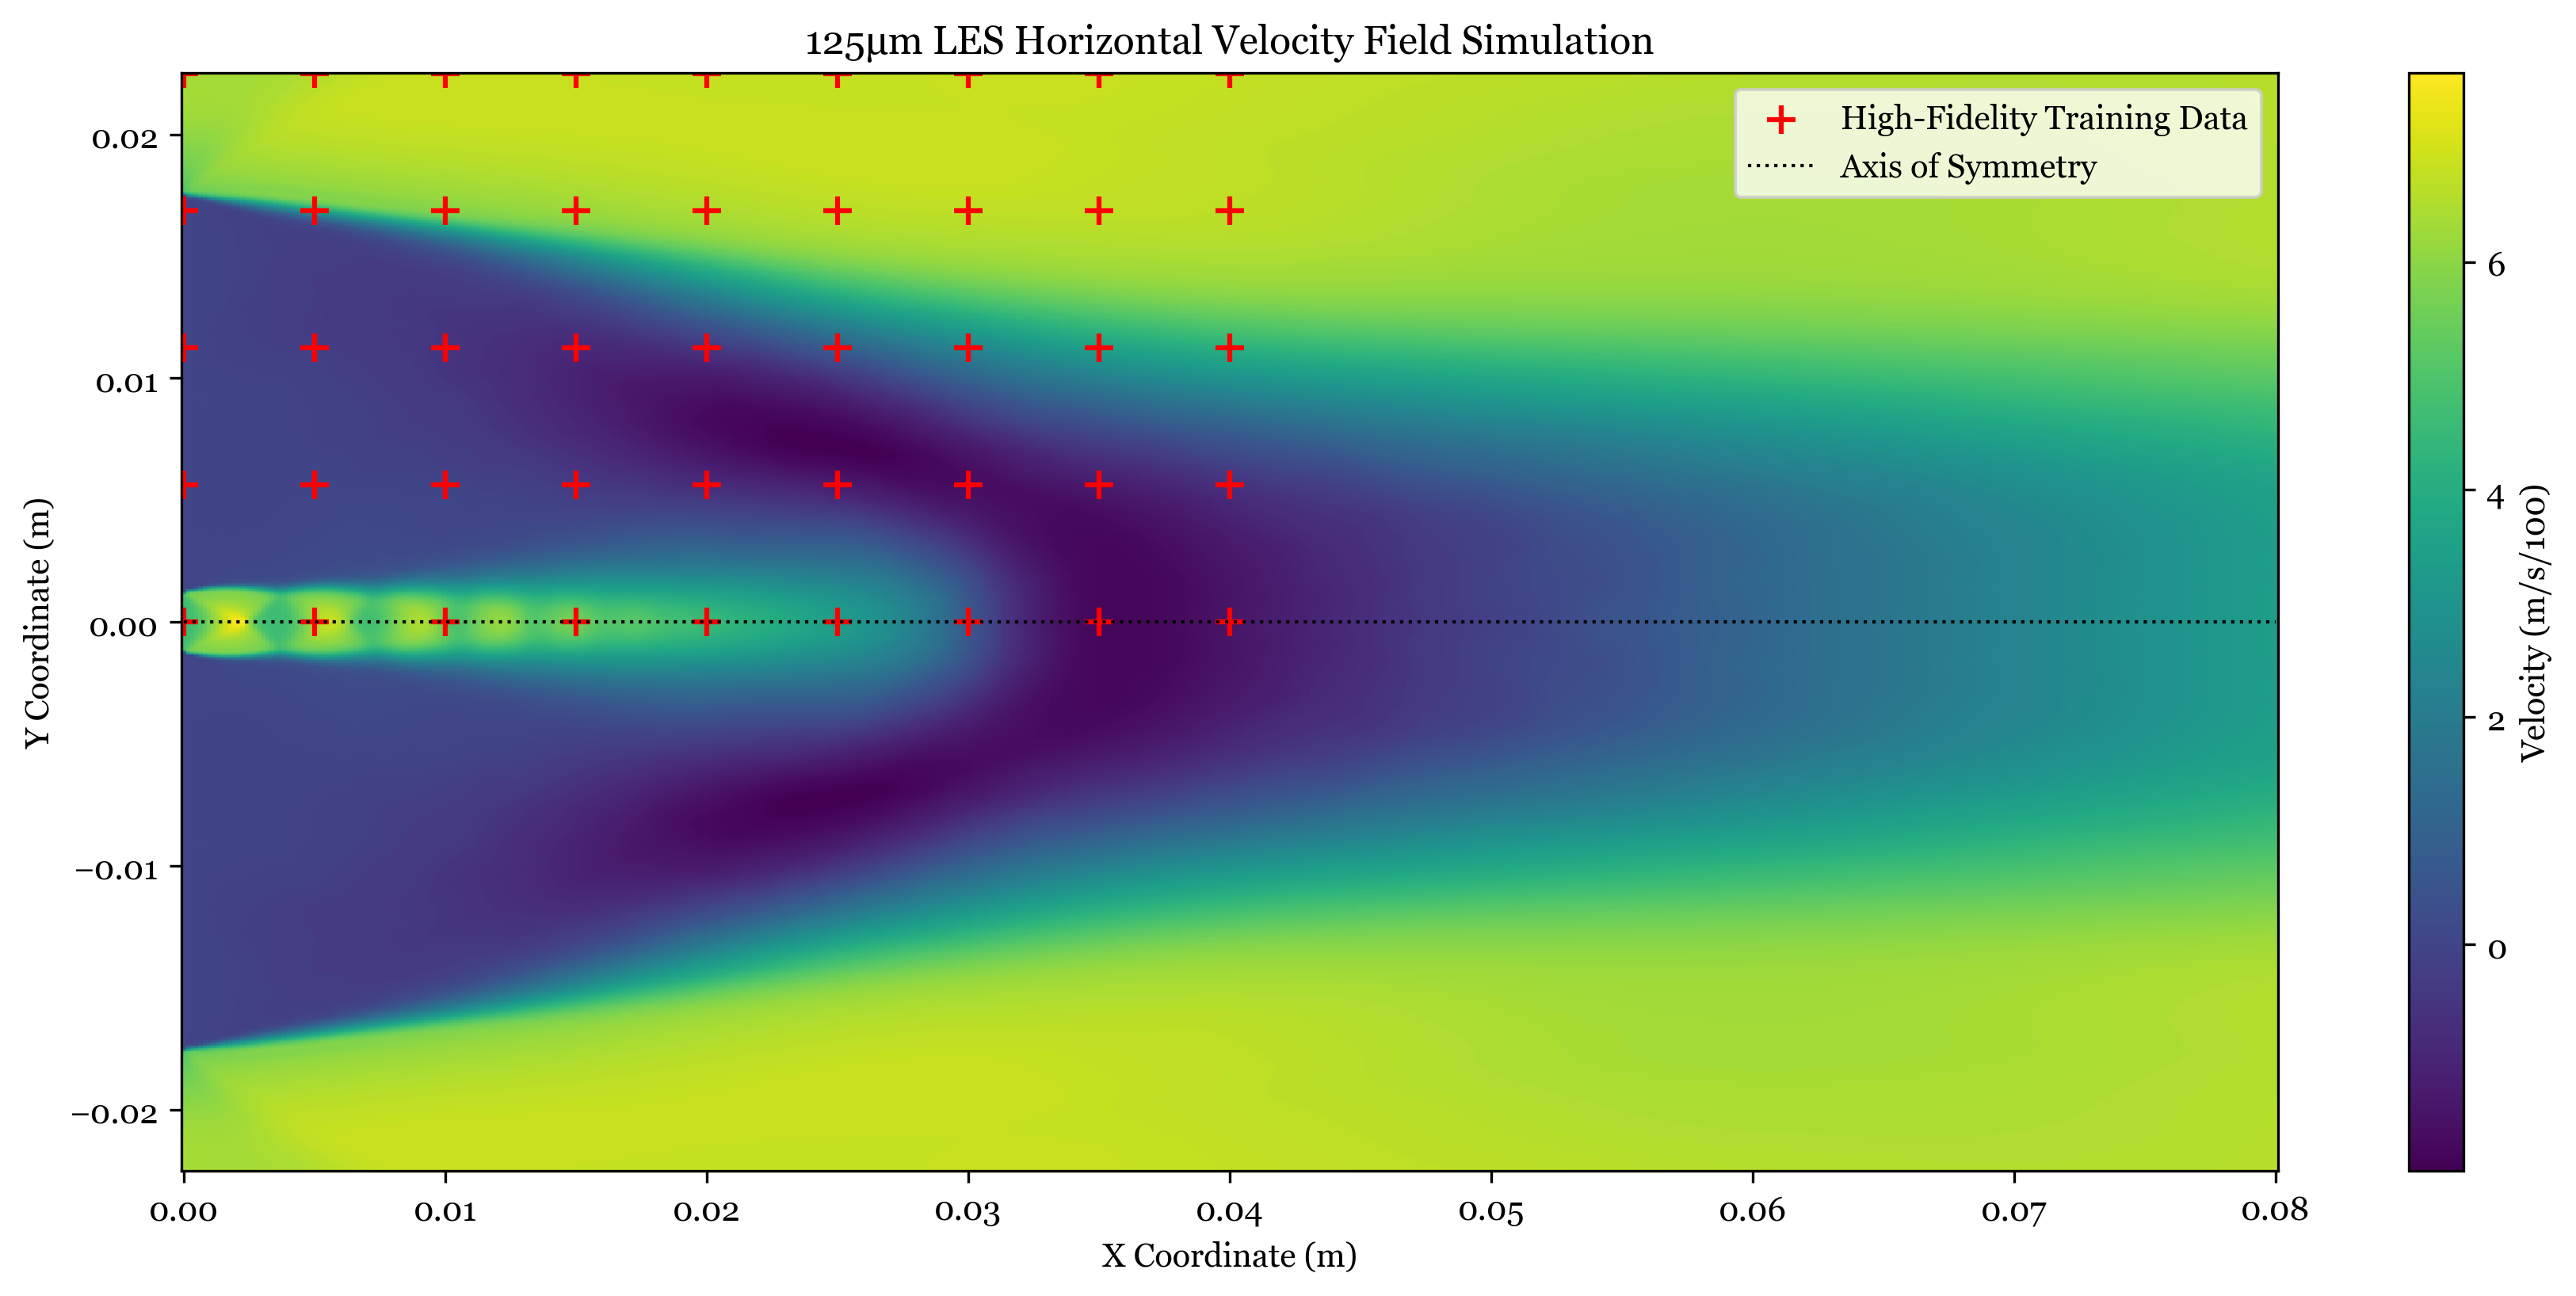

In [1]:
from util import * 

# Specifying target qoi and grid spacing 
target_qoi, grid_spacing = 'U', 0.005

# Loading data dictionary
scaler, data_dict, ratio, train_tuple, x_partitions = get_data_dict(target_qoi=target_qoi, grid_spacing=grid_spacing) 

# Extracting high-fidelity training data 
Xtrain, Ytrain = train_tuple

# Storing training and testing data
Xtest, Ytest = data_dict[4]['X'], data_dict[4][target_qoi]
data_dict[4]['X'], data_dict[4][target_qoi] = Xtrain, Ytrain

# Visualizing High-Fidelity training data 
plt.figure(figsize=(ratio * 4,6), dpi = 300)
X, Y, Z = to_grid(scaler.inverse_transform(Xtest), Ytest, N_partitions = 500)
plt.pcolormesh(X, Y, Z, cmap = 'viridis')

temp_X = np.copy(scaler.inverse_transform(Xtest))
temp_X[:,1] = -temp_X[:,1]
temp_Y = np.copy(Ytest)
X, Y, Z = to_grid(temp_X, temp_Y, N_partitions = 500)
plt.pcolormesh(X, Y, Z, cmap = 'viridis')

plt.colorbar(label = 'Velocity (m/s/100)')

plt.scatter(scaler.inverse_transform(Xtrain)[:,0], scaler.inverse_transform(Xtrain)[:,1], s = 75.0, c = 'red', label = "High-Fidelity Training Data", marker = '+')
plt.plot([0, 0.08], [0.0, 0.0], linestyle = 'dotted', linewidth =1.0, color = 'black', label = 'Axis of Symmetry')

plt.xlabel("X Coordinate (m)")
plt.ylabel("Y Coordinate (m)")
plt.title("125μm LES Horizontal Velocity Field Simulation")
plt.legend()

Training KNN Models...


100%|██████████| 4/4 [00:00<00:00,  5.75it/s]


Text(0, 0.5, 'Y Coordinate')

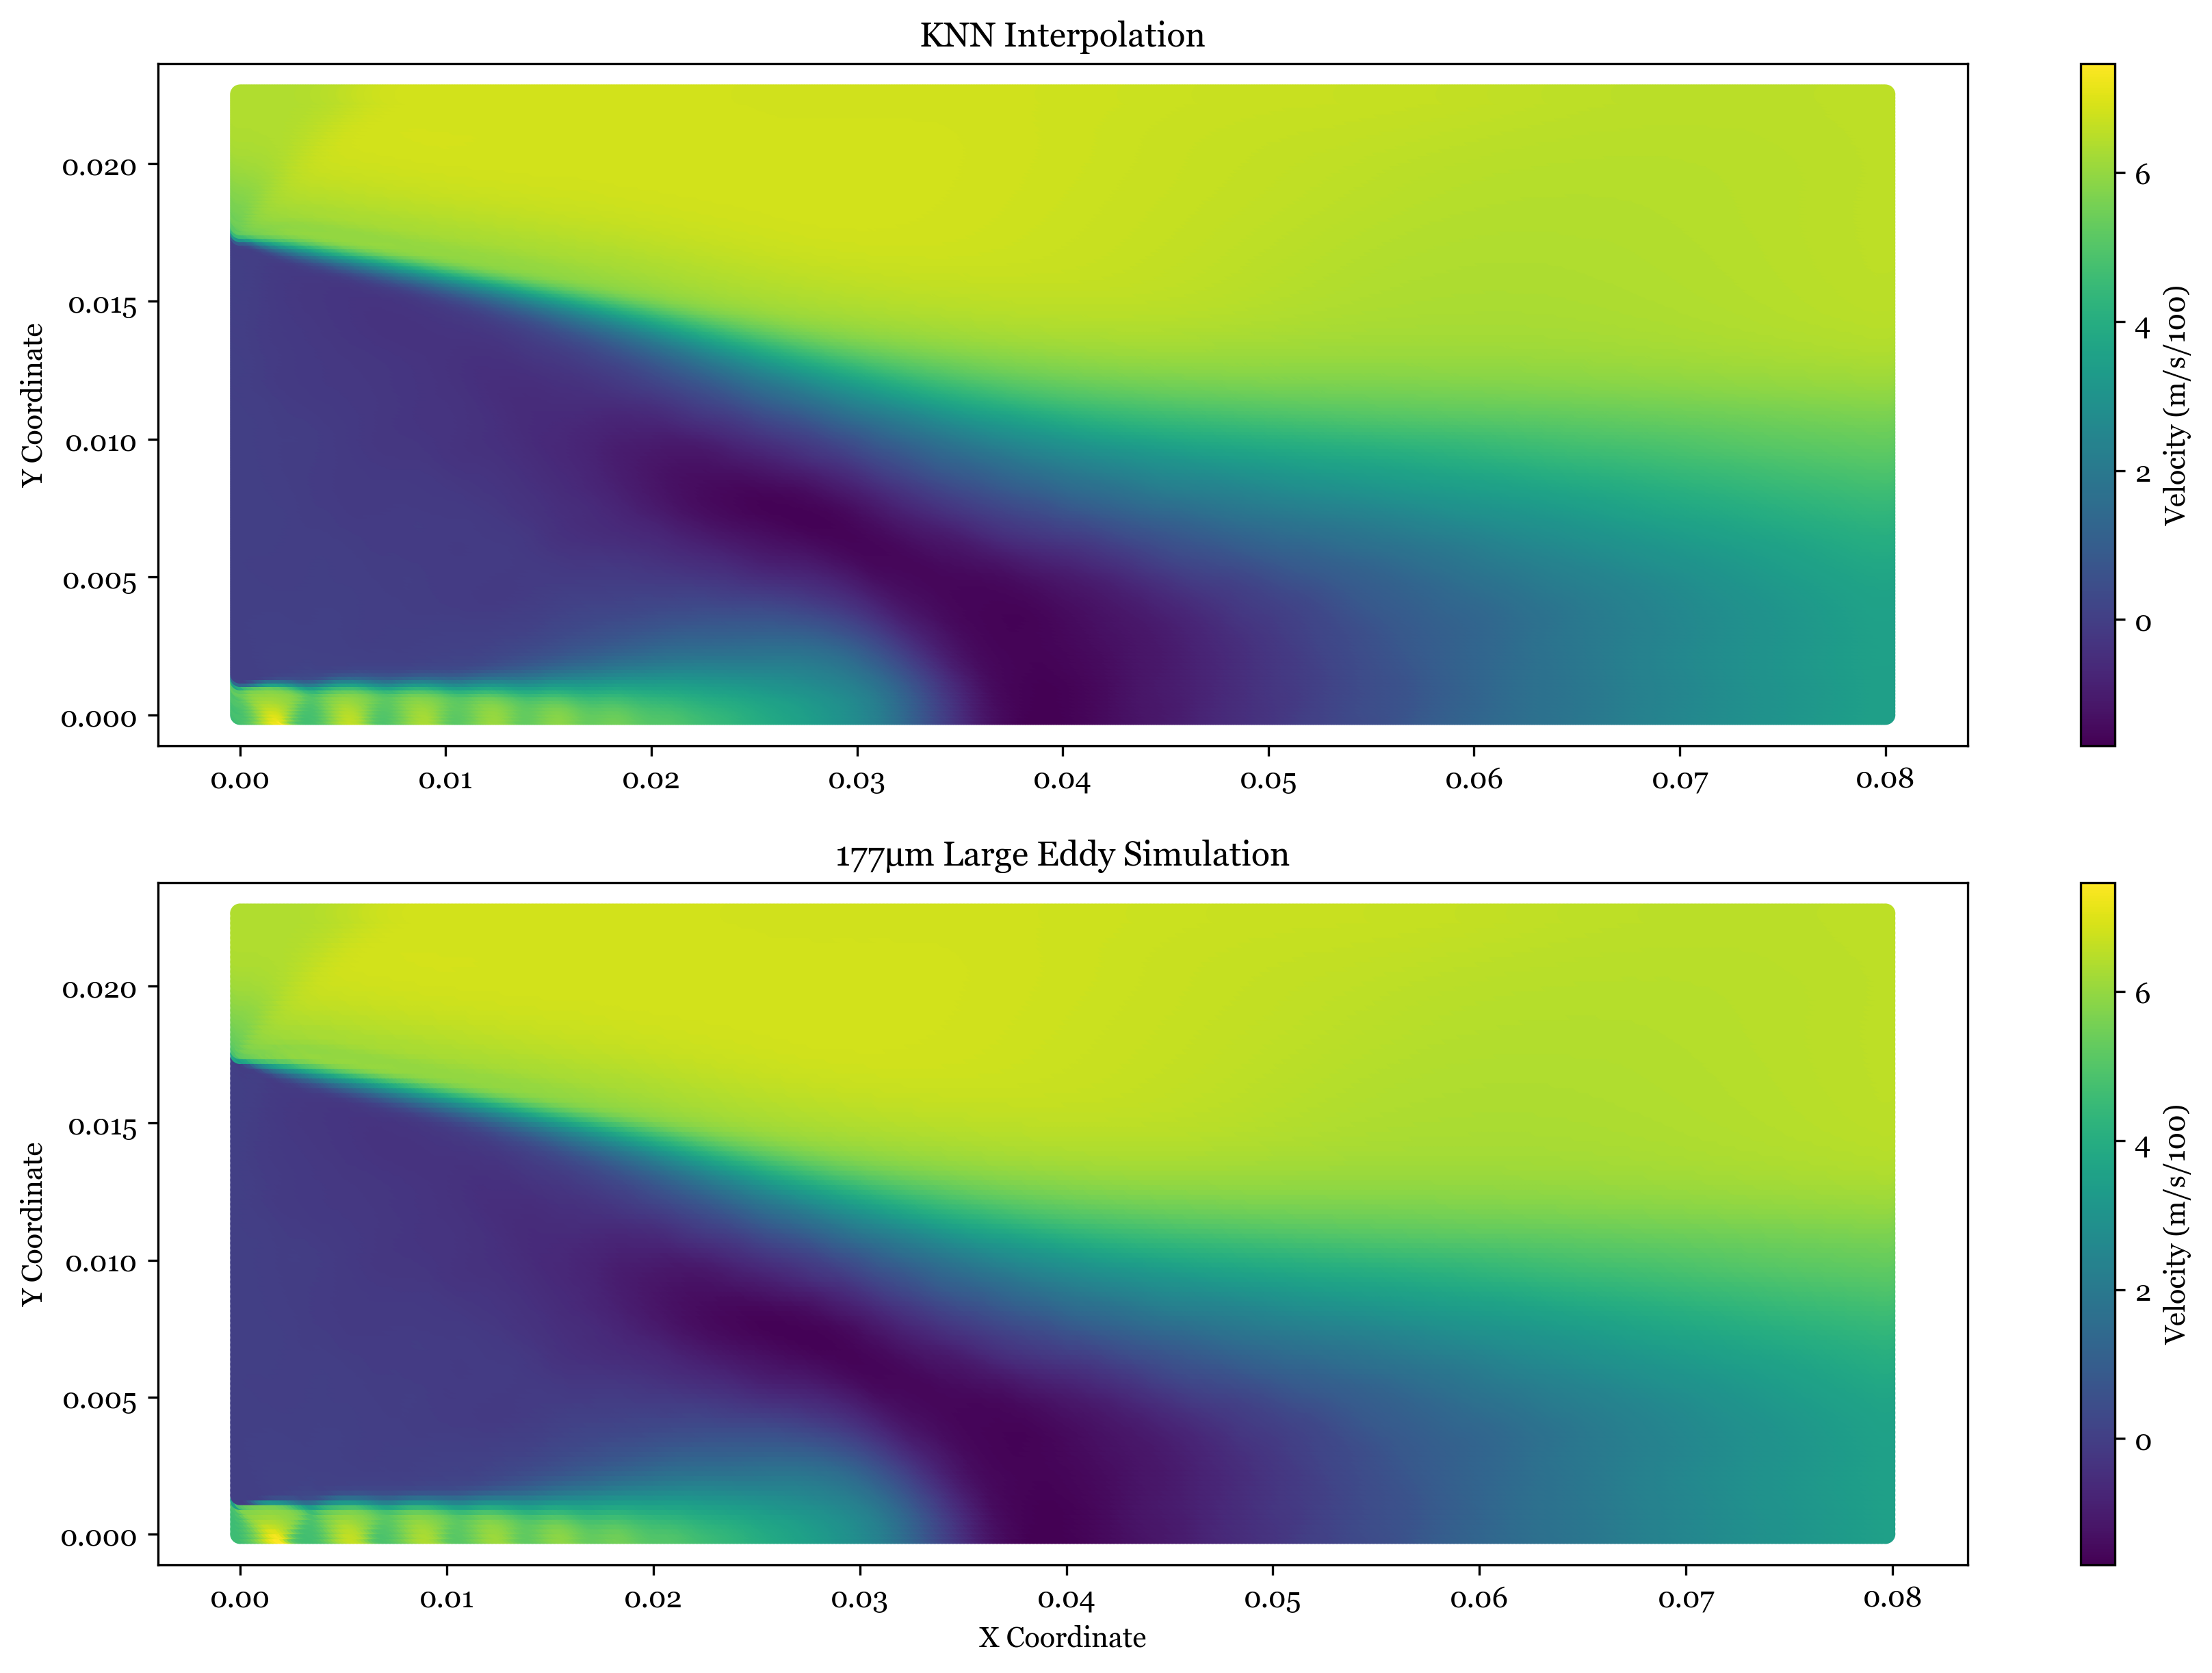

In [2]:
# Training low-fidelity surrogate models with KNN 
train_features, test_features = generate_features(data_dict, Xtrain, Xtest, n_neighbors = 10)

# Getting the 177micrometer testing predictions 
test_pred = test_features[:,-1]

# Obtaining the minimum and maximum velocity values 
vmin = min(test_pred.min(), data_dict[3][target_qoi].min())
vmax = max(test_pred.max(), data_dict[3][target_qoi].max())

plt.figure(figsize=(4*ratio, 4.75*2), dpi=300)

# First plot
plt.subplot(2, 1, 1)
plt.scatter(
    scaler.inverse_transform(Xtest)[:, 0],
    scaler.inverse_transform(Xtest)[:, 1],
    c=test_pred,
    cmap='viridis',
    vmin=vmin,
    vmax=vmax
)
plt.title("KNN Interpolation")
plt.colorbar(label='Velocity (m/s/100)')
plt.ylabel("Y Coordinate")

# Second plot
plt.subplot(2, 1, 2)
plt.scatter(
    scaler.inverse_transform(data_dict[3]['X'])[:, 0],
    scaler.inverse_transform(data_dict[3]['X'])[:, 1],
    c=data_dict[3]['Y'],
    cmap='viridis',
    vmin=vmin,
    vmax=vmax
)
plt.colorbar(label='Velocity (m/s/100)')
plt.title("177μm Large Eddy Simulation")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")

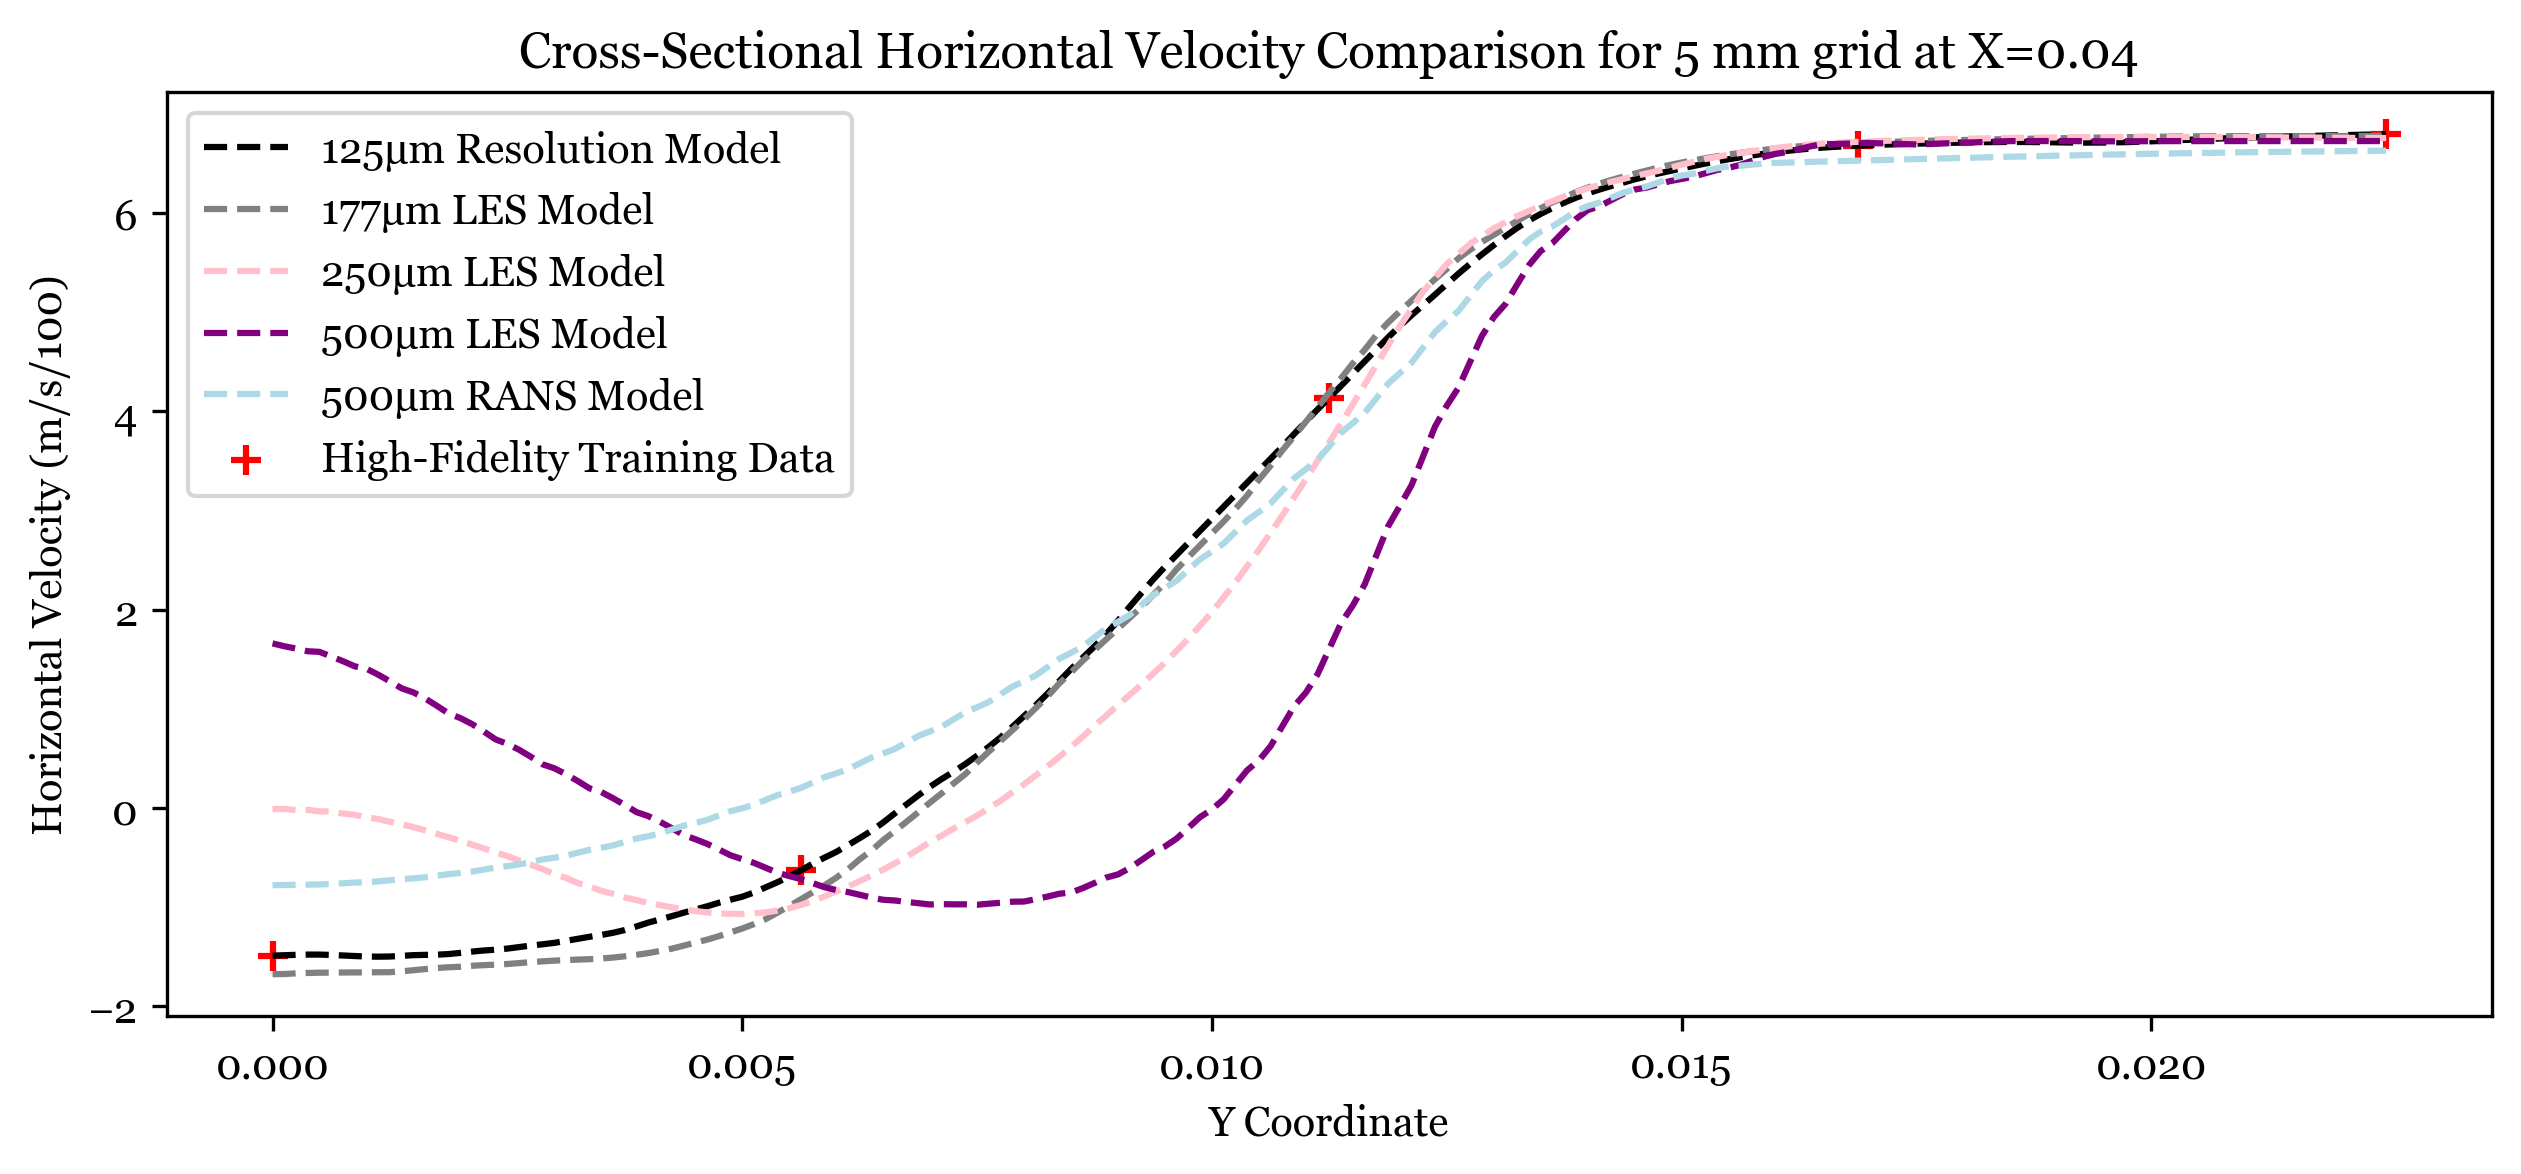

In [3]:
cs_criterion = (jnp.abs(scaler.inverse_transform(Xtest)[:,0] - 0.04) <= 1e-4) # & (scaler.inverse_transform(Xtest)[:,0] <= (x_partitions-1) * grid_spacing)
Xcs, Ycs, Fcs = Xtest[cs_criterion,:], Ytest[cs_criterion], test_features[cs_criterion, :]

plt.figure(figsize=(10,4), dpi = 300)
plt.plot(scaler.inverse_transform(Xcs)[:,1], Ycs, label = "125μm Resolution Model", color = 'black', linestyle = 'dashed')
plt.plot(scaler.inverse_transform(Xcs)[:,1], test_features[cs_criterion,5], label = "177μm LES Model", color = 'gray', linestyle = 'dashed')
plt.plot(scaler.inverse_transform(Xcs)[:,1], test_features[cs_criterion,4], label = "250μm LES Model", color = 'pink', linestyle = 'dashed')
plt.plot(scaler.inverse_transform(Xcs)[:,1], test_features[cs_criterion,3], label = "500μm LES Model", color = 'purple', linestyle = 'dashed')
plt.plot(scaler.inverse_transform(Xcs)[:,1], test_features[cs_criterion,2], label = "500μm RANS Model", color = 'lightblue', linestyle = 'dashed')
plt.scatter(scaler.inverse_transform(Xtrain)[jnp.abs(scaler.inverse_transform(Xtrain)[:,0] - 0.04) <= 1e-4, 1], Ytrain[jnp.abs(scaler.inverse_transform(Xtrain)[:,0] - 0.04) <= 1e-4], marker = '+', color = 'red', label = 'High-Fidelity Training Data', s = 50.0)
plt.xlabel("Y Coordinate")
plt.ylabel("Horizontal Velocity (m/s/100)")
plt.title("Cross-Sectional Horizontal Velocity Comparison for %d mm grid at X=0.04" % (grid_spacing * 1000))
plt.legend()

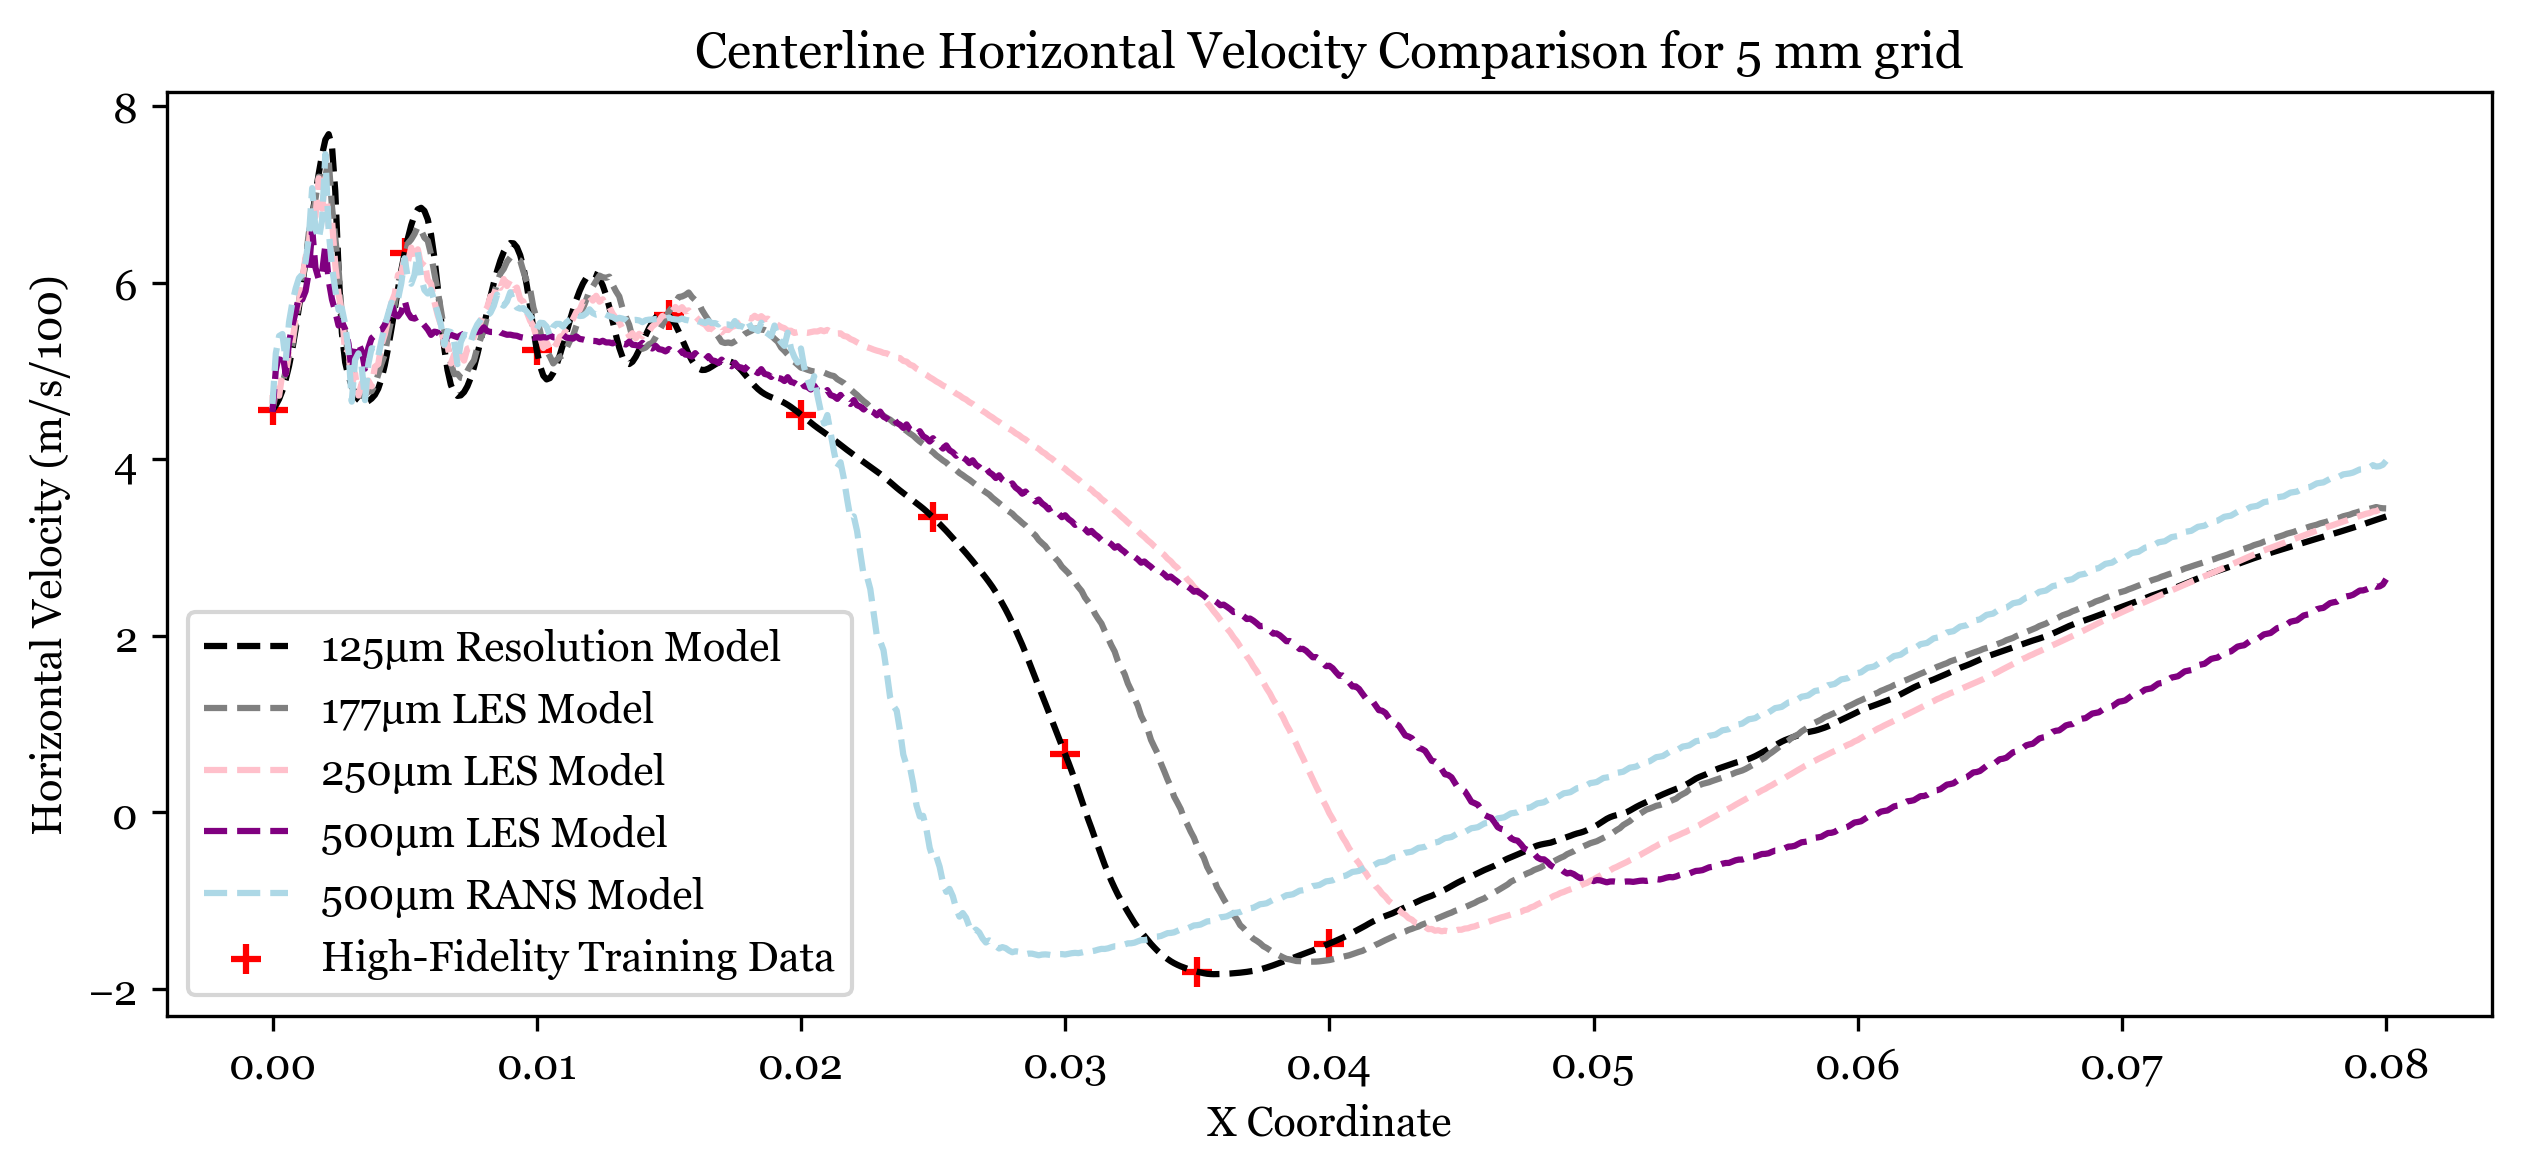

In [4]:
jet_criterion = (Xtest[:,1] == Xtest[:,1].min()) # & (scaler.inverse_transform(Xtest)[:,0] <= (x_partitions-1) * grid_spacing)
Xjet, Yjet, Fjet = Xtest[jet_criterion,:], Ytest[jet_criterion], test_features[jet_criterion, :]

plt.figure(figsize=(10,4), dpi = 300)
plt.plot(scaler.inverse_transform(Xjet)[:,0], Yjet, label = "125μm Resolution Model", color = 'black', linestyle = 'dashed')
plt.plot(scaler.inverse_transform(Xjet)[:,0], test_features[jet_criterion,5], label = "177μm LES Model", color = 'gray', linestyle = 'dashed')
plt.plot(scaler.inverse_transform(Xjet)[:,0], test_features[jet_criterion,4], label = "250μm LES Model", color = 'pink', linestyle = 'dashed')
plt.plot(scaler.inverse_transform(Xjet)[:,0], test_features[jet_criterion,3], label = "500μm LES Model", color = 'purple', linestyle = 'dashed')
plt.plot(scaler.inverse_transform(Xjet)[:,0], test_features[jet_criterion,2], label = "500μm RANS Model", color = 'lightblue', linestyle = 'dashed')
plt.scatter(scaler.inverse_transform(Xtrain)[Xtrain[:,1] == Xtrain[:,1].min(), 0], Ytrain[Xtrain[:,1] == Xtrain[:,1].min()], marker = '+', color = 'red', label = 'High-Fidelity Training Data', s = 50.0)
plt.xlabel("X Coordinate")
plt.ylabel("Horizontal Velocity (m/s/100)")
plt.title("Centerline Horizontal Velocity Comparison for %d mm grid" % (grid_spacing * 1000))
plt.legend()

In [5]:
# Creating a high-fidelity NARGP model with multi-fidelity features
import pickle 
nargp = GP(jnp.hstack((Xtrain, train_features[:,-1].reshape(-1,1))), Ytrain, NARGP_RBF, Zero, noise_var = 3e-2, epsilon = 1e-5, max_cond = 1e7, calibrate=True)
load_params = True
if not load_params:
    nargp_optimizer = ADAM(nargp, neg_mll, beta1 = 0.9, beta2=0.999)
    nargp_optimizer.run(1e-1, 10000, ['k_param'])
else:
    with open("models/nargp_params.pkl", "rb") as infile:
        nargp.set_params(pickle.load(infile))

# Creating a high-fidelity Hyperkriging model with multi-fidelity features
hk_model = GP(train_features, Ytrain, RBF, Zero, kernel_params = 0.1*jnp.ones(7), noise_var = 3e-2, epsilon = 1e-5, max_cond = 1e7, calibrate=True)
if not load_params:
    optimizer = ADAM(hk_model, neg_mll, beta1 = 0.9, beta2=0.999)
    optimizer.run(1e0, 10000, ['k_param'])
else:
    with open("models/hk_params.pkl", "rb") as infile:
        hk_model.set_params(pickle.load(infile))

# Training a Kennedy O'Hagan autoregressive estimator on just the top two levels of fidelity
delta = DeltaGP(Xtrain, Ytrain, train_features[:,-1], RBF, Zero,  max_cond = 1e7, calibrate = True, noise_var = 3e-2, epsilon = 1e-5)
if not load_params:
    koh_optimizer = ADAM(delta, delta_neg_mll, beta1 = 0.9, beta2 = 0.999)
    koh_optimizer.run(1e-1, 10000, ['rho', 'k_param'])
else:
    with open("models/koh_params.pkl", "rb") as infile:
        delta.set_params(pickle.load(infile))

# Training a high-fidelity Kriging model 
kr_model = GP(Xtrain, Ytrain, RBF, Zero, noise_var = 3e-2, epsilon = 1e-5, max_cond = 1e7, calibrate=True)
if not load_params:
    kr_optimizer = ADAM(kr_model, neg_mll, beta1 = 0.9, beta2=0.999)
    kr_optimizer.run(1e-2, 10000, ['k_param'])
else:
    with open("models/kr_params.pkl", "rb") as infile:
        kr_model.set_params(pickle.load(infile))

Calibrated white noise variance: 3.0000e-02
Calibrated white noise variance: 3.0000e-02
Calibrated white noise variance: 3.0000e-02
Calibrated white noise variance: 3.0000e-02


In [6]:
# # Saving parameters (if uncommented)
# with open("models/nargp_params.pkl", "wb") as outfile: 
#     pickle.dump(nargp.p,outfile)

# with open("models/hk_params.pkl", "wb") as outfile:
#     pickle.dump(hk_model.p, outfile)

# with open("models/koh_params.pkl", "wb") as outfile:
#     pickle.dump(delta.p, outfile)

# with open("models/kr_params.pkl", "wb") as outfile:
#     pickle.dump(kr_model.p, outfile)

In [7]:
from sklearn.metrics import mean_squared_error as MSE 
hk_mean, _ = hk_model.predict(test_features, full_cov = False) 

# Making predictions using the kennedy o'hagan estimator
delta_mean, _ = delta.predict(Xtest, full_cov = False)
koh_mean = delta.p['rho'] * test_features[:,-1] + delta_mean 

# Making predictions using the nargp estimator
nargp_mean, _ = nargp.predict(jnp.hstack((Xtest, test_features[:,-1].reshape(-1,1))), full_cov=False)

# Making predictions using the high-fidelity Kriging model
kr_mean, _ = kr_model.predict(Xtest, full_cov = False)

# Specifying only the training data within the grid 
grid_criterion = (Xtest[:,0] <= (x_partitions-1) * grid_spacing)

In [29]:
data_dict[3]['X'].shape

(58179, 2)

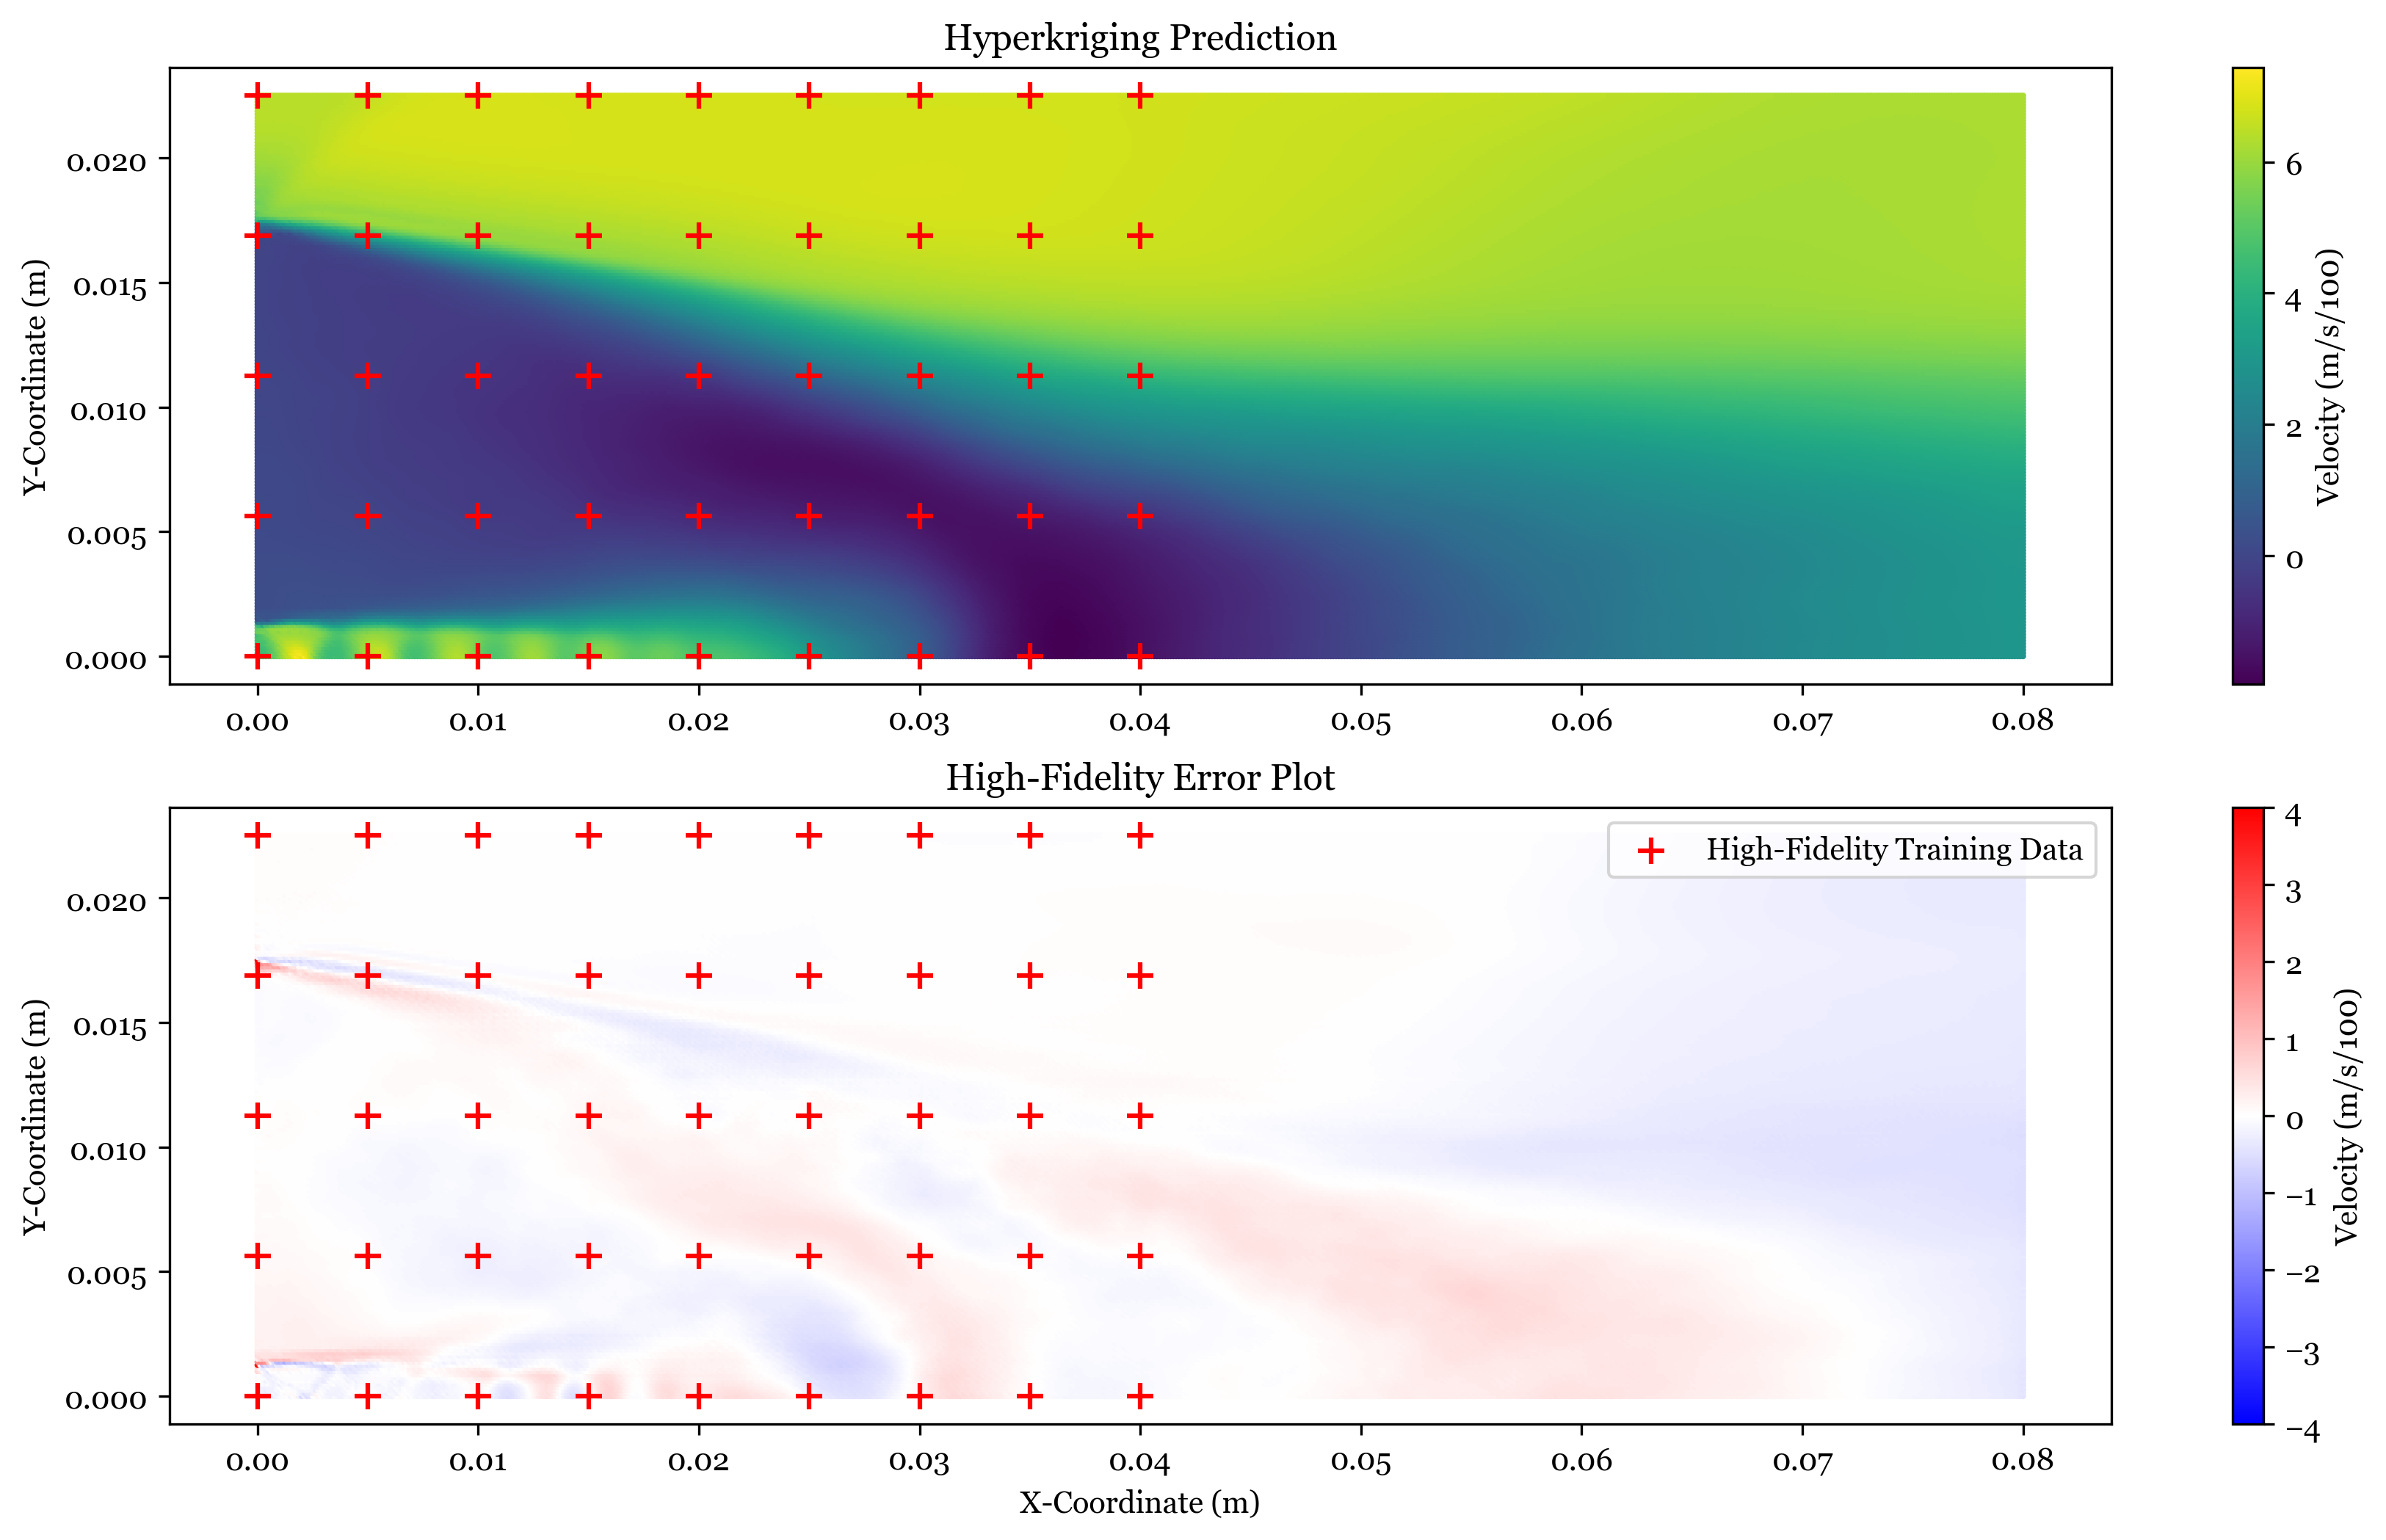

In [24]:
# Making predictions on test features
plt.figure(figsize=(4*ratio,4*2), dpi = 300)

plt.subplot(2,1,1)
plt.title("Hyperkriging Prediction")

plt.scatter(scaler.inverse_transform(Xtest)[:,0], scaler.inverse_transform(Xtest)[:,1], c = hk_mean, cmap = 'viridis', s = 1.0)
plt.colorbar(label = "Velocity (m/s/100)")
plt.scatter(scaler.inverse_transform(Xtrain)[:,0], scaler.inverse_transform(Xtrain)[:,1], c = 'red', s = 75, marker = '+', label = "High-Fidelity Training Data")
plt.ylabel("Y-Coordinate (m)")

plt.subplot(2,1,2)
from matplotlib.colors import TwoSlopeNorm
diff = hk_mean - Ytest
norm = TwoSlopeNorm(vmin=-4, vcenter=0, vmax=4)
im = plt.scatter(scaler.inverse_transform(Xtest)[:,0], scaler.inverse_transform(Xtest)[:,1], c = hk_mean - Ytest, cmap = 'bwr', norm = norm, s = 1.0)
cbar = plt.colorbar(label = "Velocity (m/s/100)")
plt.title("High-Fidelity Error Plot")
plt.scatter(scaler.inverse_transform(Xtrain)[:,0], scaler.inverse_transform(Xtrain)[:,1], c = 'red', s = 75, marker = '+', label = "High-Fidelity Training Data")
plt.ylabel("Y-Coordinate (m)")
plt.xlabel("X-Coordinate (m)")
plt.legend()
plt.savefig("results/hk_prediction_uniform.png")

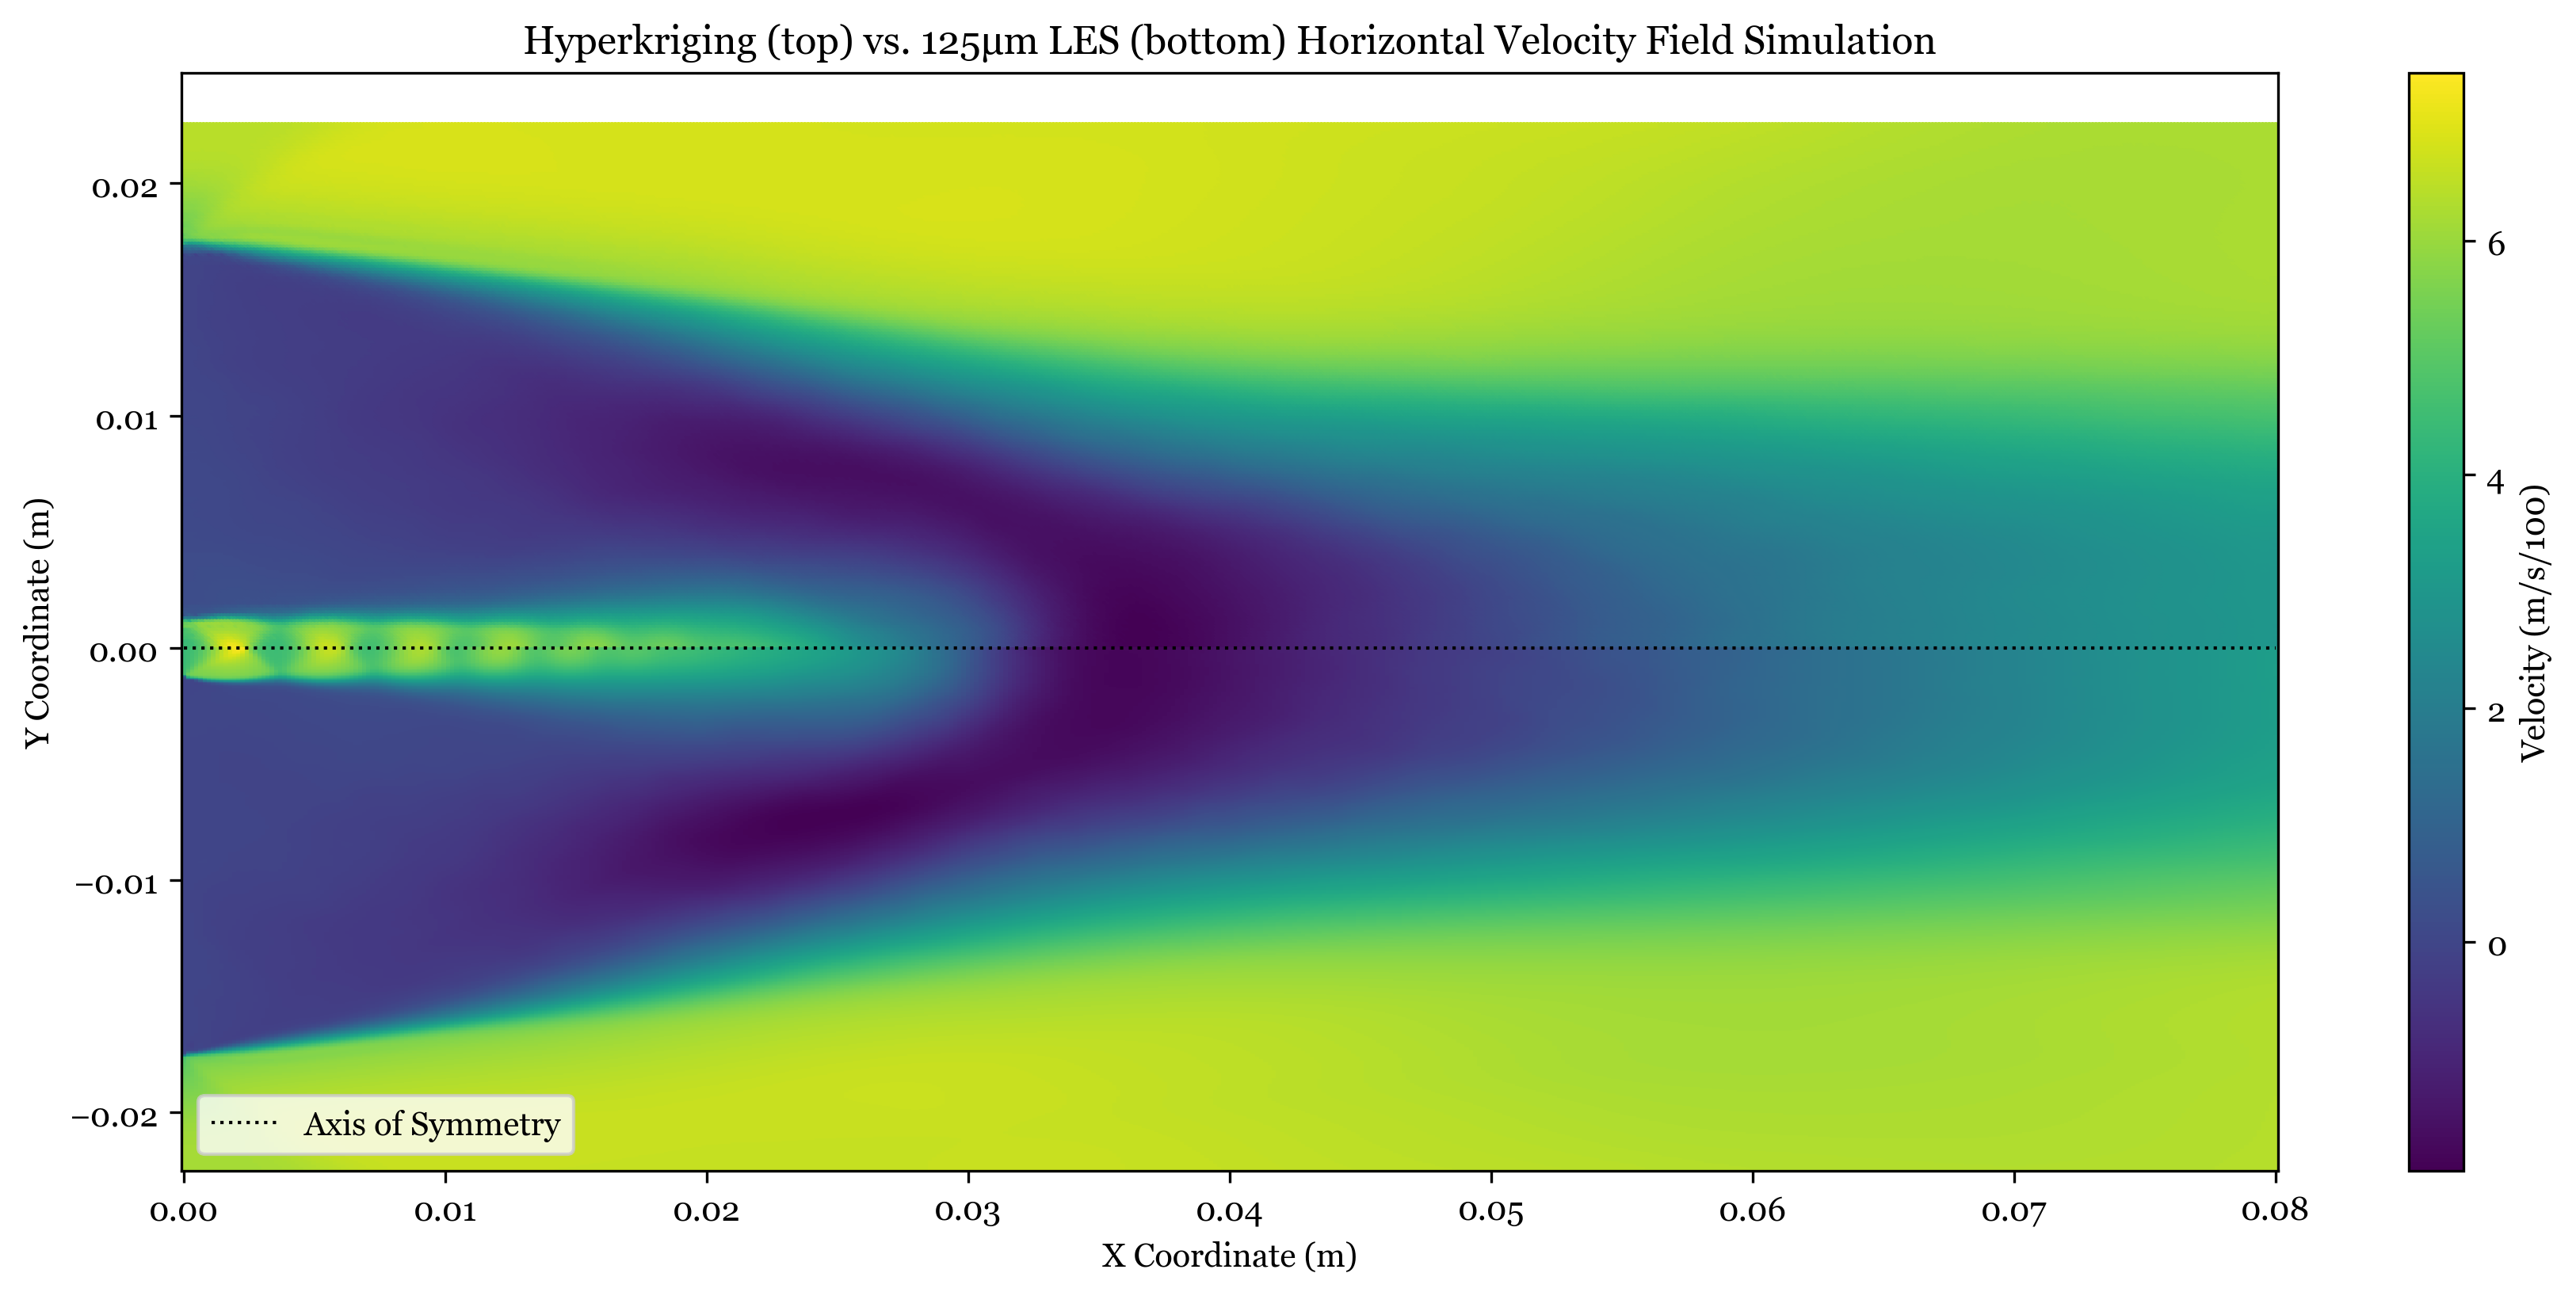

In [23]:
# Visualizing High-Fidelity training data 
plt.figure(figsize=(ratio * 4,6), dpi = 300)


plt.scatter(scaler.inverse_transform(Xtest)[:,0], scaler.inverse_transform(Xtest)[:,1], c = hk_mean, cmap = 'viridis', s = 1.0)
plt.colorbar(label = "Velocity (m/s/100)")


X, Y, Z = to_grid(temp_X, temp_Y, N_partitions = 500)
plt.pcolormesh(X, Y, Z, cmap = 'viridis')

plt.plot([0, 0.08], [0.0, 0.0], linestyle = 'dotted', linewidth =1.0, color = 'black', label = 'Axis of Symmetry')

plt.xlabel("X Coordinate (m)")
plt.ylabel("Y Coordinate (m)")
plt.title("Hyperkriging (top) vs. 125μm LES (bottom) Horizontal Velocity Field Simulation")
plt.legend()
plt.savefig("results/hk_vs_125_comparison.png")

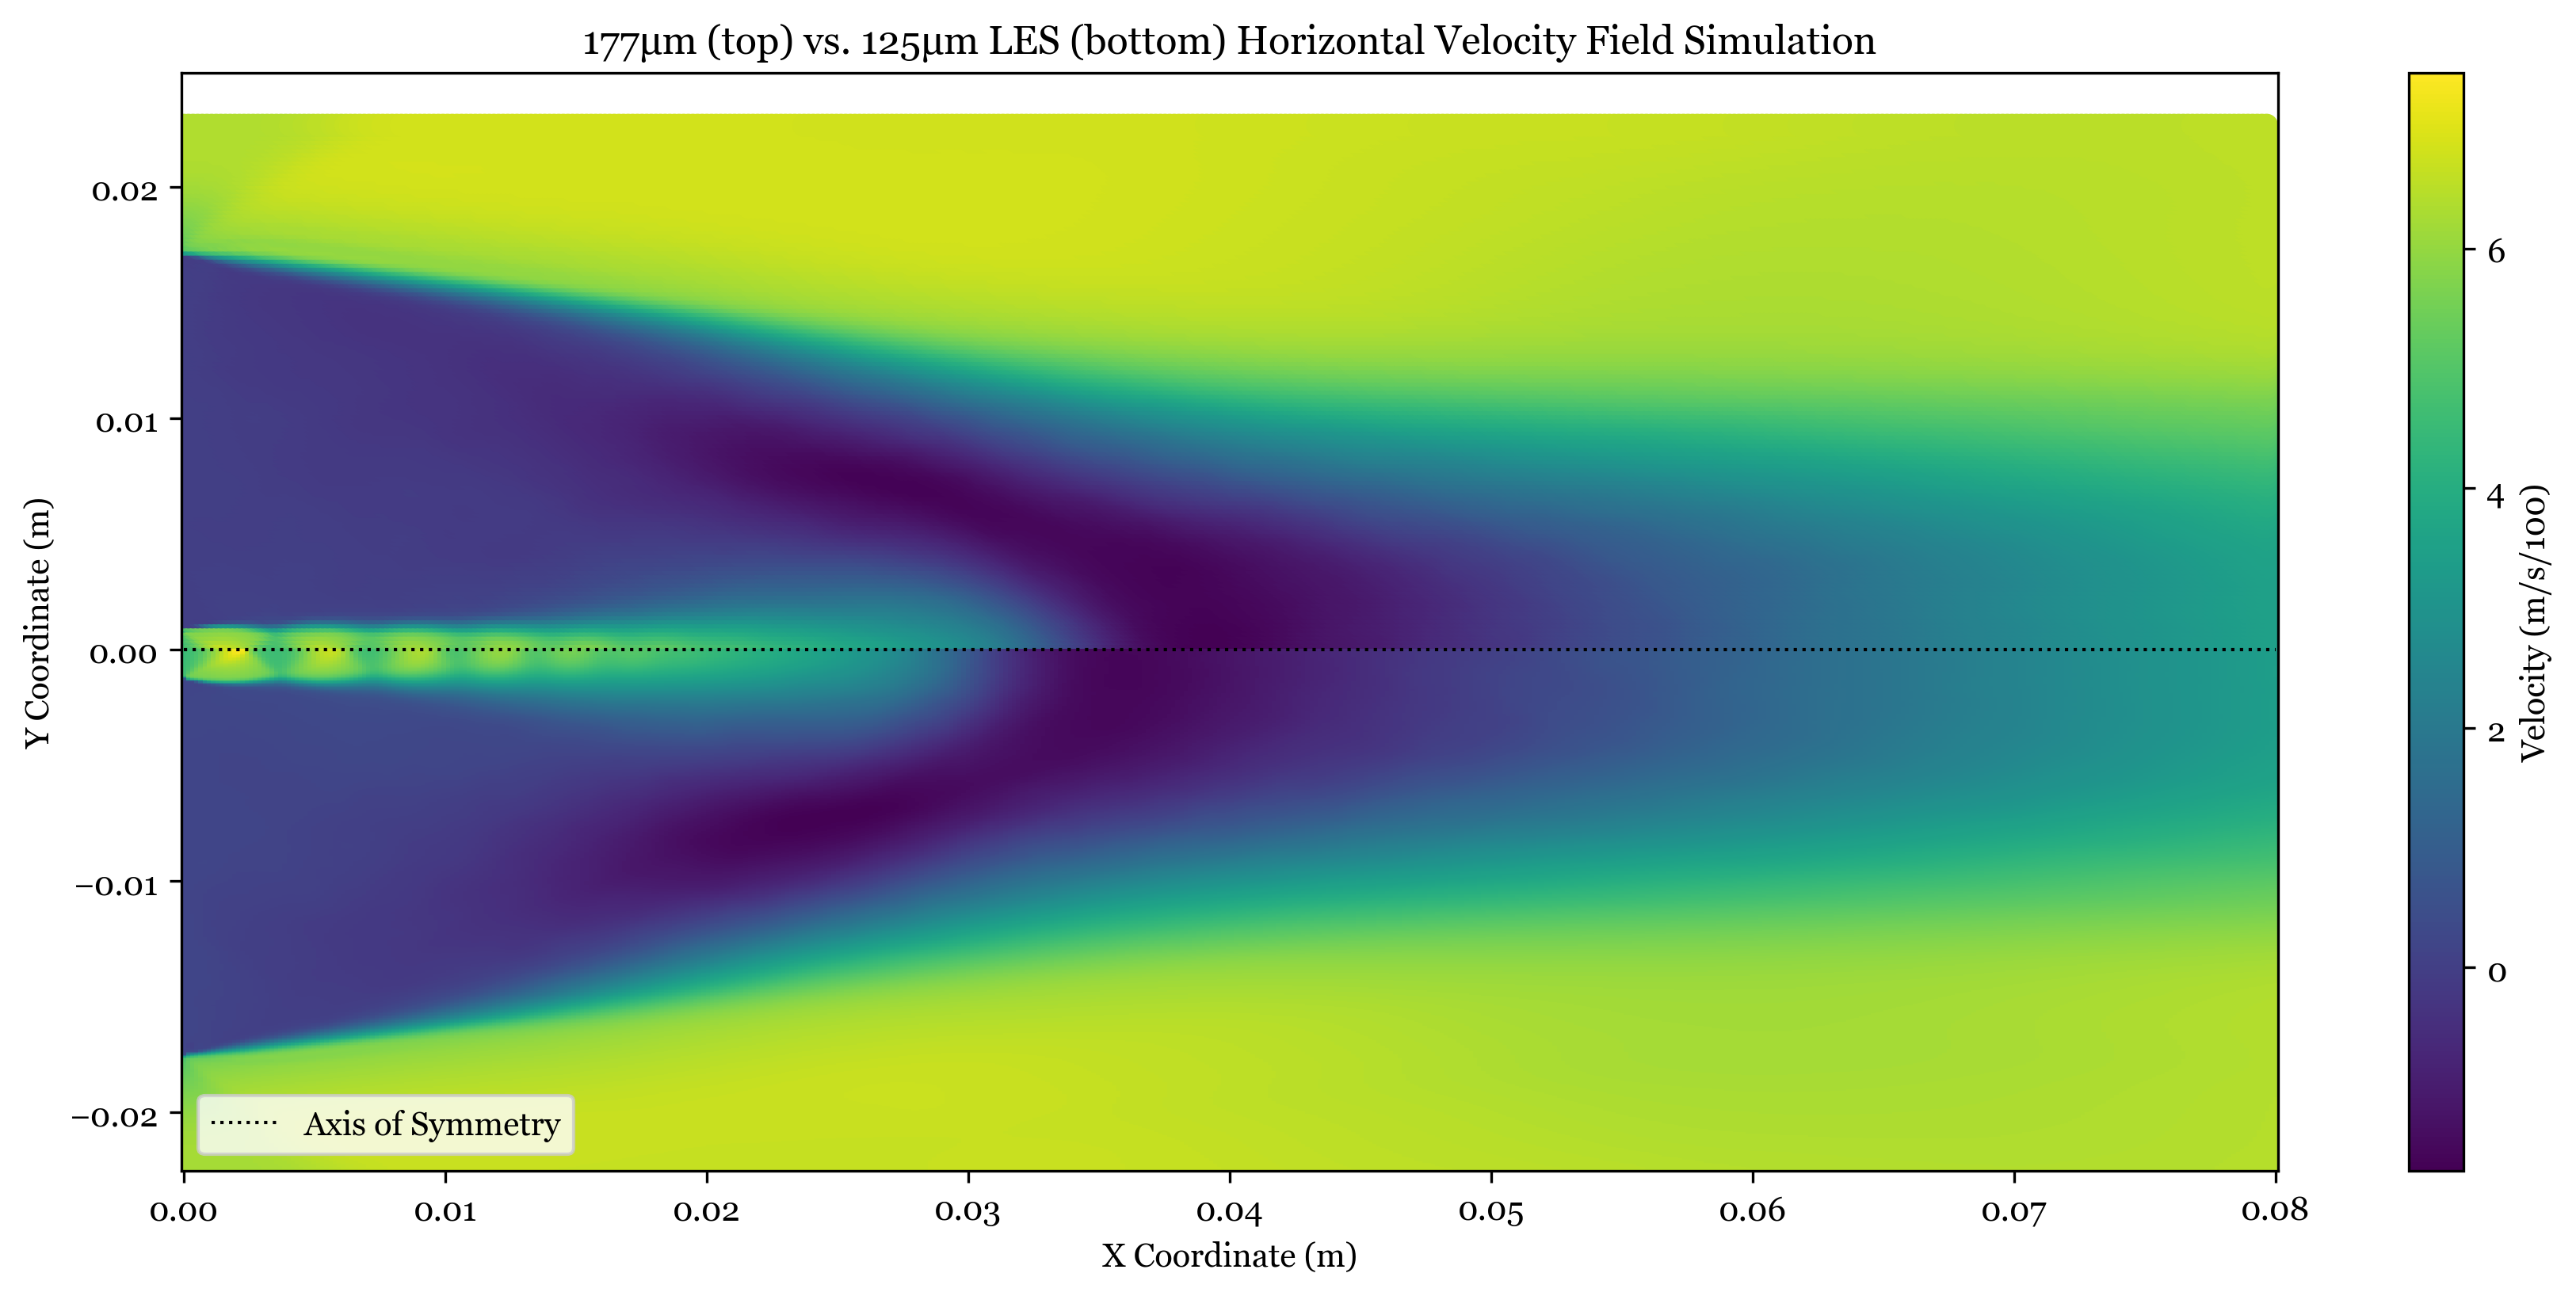

In [22]:
# Visualizing High-Fidelity training data 
plt.figure(figsize=(ratio * 4,6), dpi = 300)


plt.scatter(
    scaler.inverse_transform(data_dict[3]['X'])[:, 0],
    scaler.inverse_transform(data_dict[3]['X'])[:, 1],
    c=data_dict[3]['Y'],
    cmap='viridis',
    vmin=vmin,
    vmax=vmax
)
plt.colorbar(label = "Velocity (m/s/100)")


X, Y, Z = to_grid(temp_X, temp_Y, N_partitions = 500)
plt.pcolormesh(X, Y, Z, cmap = 'viridis')

plt.plot([0, 0.08], [0.0, 0.0], linestyle = 'dotted', linewidth =1.0, color = 'black', label = 'Axis of Symmetry')

plt.xlabel("X Coordinate (m)")
plt.ylabel("Y Coordinate (m)")
plt.title("177μm (top) vs. 125μm LES (bottom) Horizontal Velocity Field Simulation")
plt.legend()
plt.savefig("results/177_vs_125_comparison.png")

In [21]:
print("Method           Grid RMSE      Grid R^2   Log MLL")
print("---------------------------------------------------------------------------")
print("Hyperkriging   &  %.4f  &  %.4f  &  %.4f \\\\" % (jnp.sqrt(MSE(Ytest[grid_criterion], hk_mean[grid_criterion])), np.corrcoef(Ytest[grid_criterion], hk_mean[grid_criterion])[0,1], -neg_mll(hk_model, hk_model.p)))
print("Kennedy OH     &  %.4f  &  %.4f  &  %.4f \\\\" % (jnp.sqrt(MSE(Ytest[grid_criterion], koh_mean[grid_criterion])), np.corrcoef(Ytest[grid_criterion], koh_mean[grid_criterion])[0,1], -delta_neg_mll(delta, delta.p)))
print("NARGP          &  %.4f  &  %.4f  &  %.4f \\\\" % (jnp.sqrt(MSE(Ytest[grid_criterion], nargp_mean[grid_criterion])), np.corrcoef(Ytest[grid_criterion], nargp_mean[grid_criterion])[0,1], -neg_mll(nargp, nargp.p)))
print("Kriging        &  %.4f  &  %.4f  &  %.4f \\\\" % (jnp.sqrt(MSE(Ytest[grid_criterion], kr_mean[grid_criterion])), np.corrcoef(Ytest[grid_criterion], kr_mean[grid_criterion])[0,1], -neg_mll(kr_model, kr_model.p)))
print("177μm          &  %.4f  &  %.4f  &  -- \\\\ " %  (jnp.sqrt(MSE(Ytest[grid_criterion], test_features[grid_criterion, 5])), np.corrcoef(Ytest[grid_criterion], test_features[grid_criterion, 5])[0,1]))
print("250μm          &  %.4f  &  %.4f  &  -- \\\\ " %  (jnp.sqrt(MSE(Ytest[grid_criterion], test_features[grid_criterion, 4])), np.corrcoef(Ytest[grid_criterion], test_features[grid_criterion, 4])[0,1]))
print("500μm          &  %.4f  &  %.4f  &  -- \\\\ " %  (jnp.sqrt(MSE(Ytest[grid_criterion], test_features[grid_criterion, 3])), np.corrcoef(Ytest[grid_criterion], test_features[grid_criterion, 3])[0,1]))
print("RANSμm         &  %.4f  &  %.4f  &  -- \\\\  \\hline" %  (jnp.sqrt(MSE(Ytest[grid_criterion], test_features[grid_criterion, 2])), np.corrcoef(Ytest[grid_criterion], test_features[grid_criterion, 2])[0,1]))

Method           Grid RMSE      Grid R^2   Log MLL
---------------------------------------------------------------------------
Hyperkriging   &  0.1605  &  0.9988  &  -14.3494 \\
Kennedy OH     &  0.3978  &  0.9928  &  -9.2880 \\
NARGP          &  0.2647  &  0.9968  &  -15.2684 \\
Kriging        &  0.9891  &  0.9566  &  -17.5662 \\
177μm          &  0.4123  &  0.9921  &  -- \\ 
250μm          &  0.7878  &  0.9705  &  -- \\ 
500μm          &  1.1332  &  0.9392  &  -- \\ 
RANSμm         &  0.6772  &  0.9782  &  -- \\  \hline


In [12]:
# Selecting only the points on the jet
jet_criterion = (Xtest[:,1] == Xtest[:,1].min()) # & (scaler.inverse_transform(Xtest)[:,0] <= (x_partitions-1) * grid_spacing)
Xjet, Yjet, Fjet = Xtest[jet_criterion,:], Ytest[jet_criterion], test_features[jet_criterion, :]

Xtrain_jet, Ytrain_jet, Ftrain_jet = Xtrain[Xtrain[:,1] == Xtrain[:,1].min(),:], Ytrain[Xtrain[:,1] == Xtrain[:,1].min()], train_features[Xtrain[:,1] == Xtrain[:,1].min(), :]

In [13]:
# High-Fidelity NARGP Model
nargp = GP(jnp.hstack((Xtrain_jet, Ftrain_jet[:,-1].reshape(-1,1))), Ytrain_jet, NARGP_RBF, Constant, noise_var = 1e-6, epsilon = 1e-12, max_cond = 1e7, calibrate=True)
load_params = False
if not load_params:
    nargp_optimizer = ADAM(nargp, neg_mll, beta1 = 0.9, beta2=0.999)
    nargp_optimizer.run(1e-1, 10000, ['k_param'])
else:
    with open("models/nargp_params.pkl", "rb") as infile:
        nargp.set_params(pickle.load(infile))

# Creating a high-fidelity Hyperkriging model with multi-fidelity features
hk_model = GP(Ftrain_jet, Ytrain_jet, RBF, Constant,noise_var = 1e-6, epsilon = 1e-12, max_cond = 1e7, calibrate=True)
if not load_params:
    optimizer = ADAM(hk_model, neg_mll, beta1 = 0.9, beta2=0.999)
    optimizer.run(1e-1, 10000, ['k_param'])
else:
    with open("models/hk_params.pkl", "rb") as infile:
        hk_model.set_params(pickle.load(infile))

# Training a Kennedy O'Hagan autoregressive estimator on just the top two levels of fidelity
delta = DeltaGP(Xtrain_jet, Ytrain_jet, Ftrain_jet[:,-1], RBF, Constant,  max_cond = 1e7, calibrate = True, noise_var = 1e-6, epsilon = 1e-12)
if not load_params:
    koh_optimizer = ADAM(delta, delta_neg_mll, beta1 = 0.9, beta2 = 0.999)
    koh_optimizer.run(1e-1, 10000, ['rho', 'k_param'])
else:
    with open("models/koh_params.pkl", "rb") as infile:
        delta.set_params(pickle.load(infile))

# Training a high-fidelity Kriging model 
kr_model = GP(Xtrain_jet, Ytrain_jet, RBF, Constant, noise_var = 3e-2, epsilon = 1e-5, max_cond = 1e7, calibrate=True)
if not load_params:
    kr_optimizer = ADAM(kr_model, neg_mll, beta1 = 0.9, beta2=0.999)
    kr_optimizer.run(1e-2, 10000, ['k_param'])
else:
    with open("models/kr_params.pkl", "rb") as infile:
        kr_model.set_params(pickle.load(infile))

Calibrated white noise variance: 1.0000e-06


100%|██████████| 10000/10000 [00:17<00:00, 578.46it/s, Loss: 1.5268e+01]


Calibrated white noise variance: 1.0000e-06


100%|██████████| 10000/10000 [00:16<00:00, 616.06it/s, Loss: 1.4526e+01]


Calibrated white noise variance: 1.0000e-06


100%|██████████| 10000/10000 [00:17<00:00, 574.64it/s, Loss: 9.2880e+00]


Calibrated white noise variance: 3.0000e-02


100%|██████████| 10000/10000 [00:14<00:00, 676.81it/s, Loss: 1.7566e+01]


In [14]:
optimizer.run(1e0, 10000, ['k_param'])

100%|██████████| 10000/10000 [00:14<00:00, 685.88it/s, Loss: 1.4364e+01]


{'noise_var': Array(-13.81551006, dtype=float64, weak_type=True),
 'k_param': Array([  6.08052974, 704.69181584,   1.84831225,   1.07430003,
        704.86999422, 704.68891814,  34.91332346], dtype=float64),
 'm_param': Array([2.9958429], dtype=float64)}

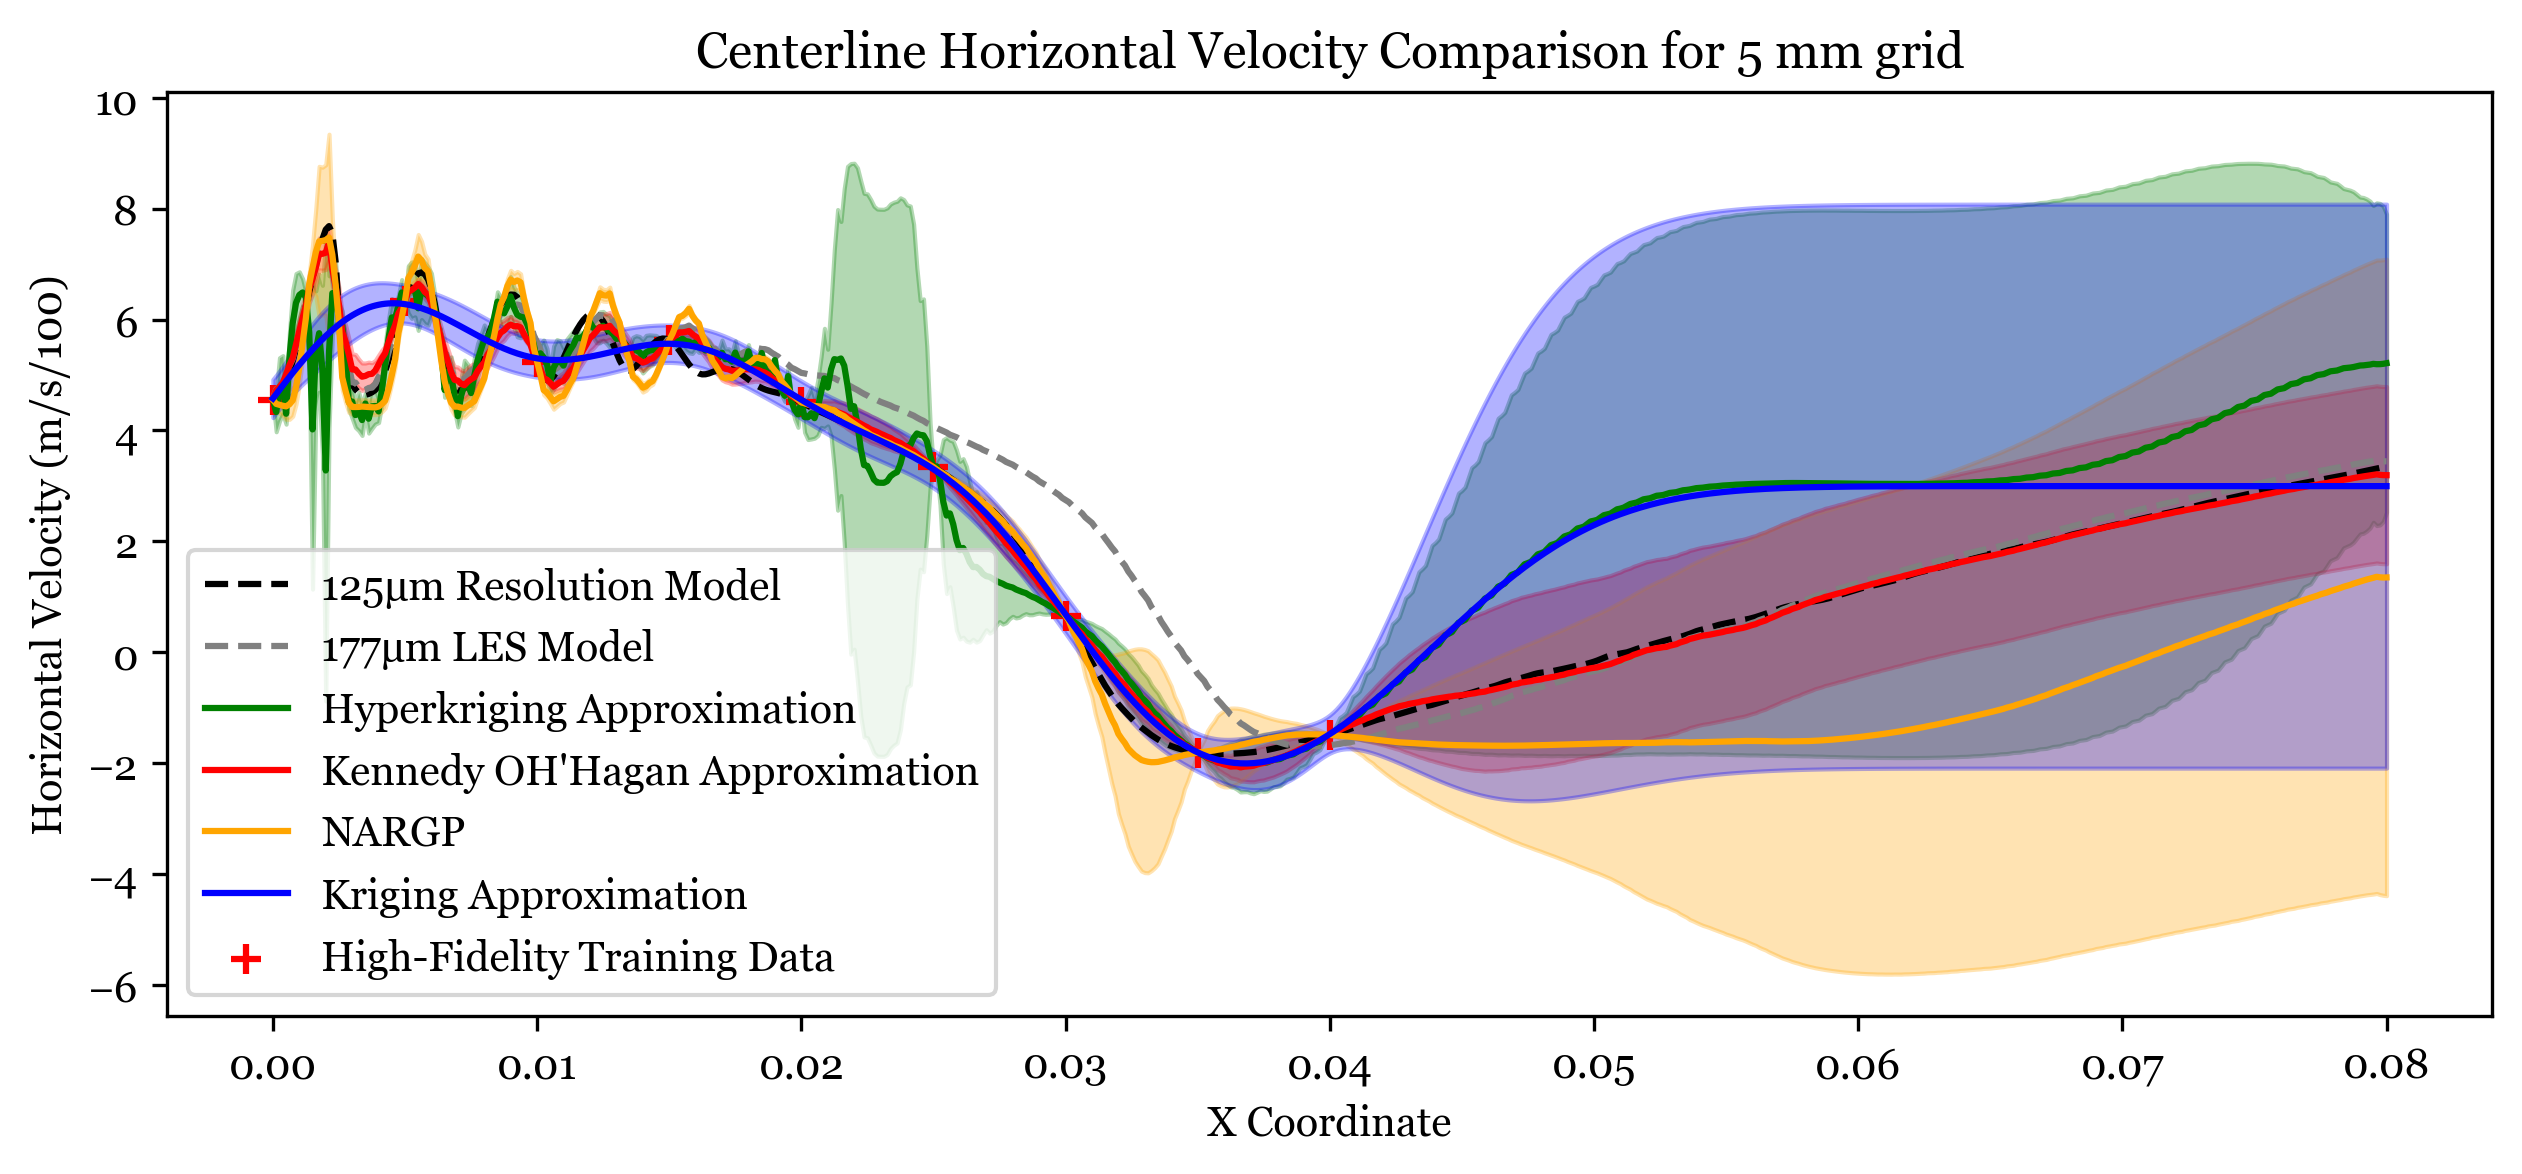

In [15]:
hk_jet, cov_jet = hk_model.predict(Fjet)
conf = 2*np.sqrt(np.diag(cov_jet))

delta_mean, delta_cov = delta.predict(Xjet, full_cov = False)
koh_jet, koh_cov_jet = delta.p['rho'] * Fjet[:,-1] + delta_mean, delta_cov
koh_conf = 2*np.sqrt(koh_cov_jet)

kr_jet, kr_cov = kr_model.predict(Xjet)
kr_conf = 2 * np.sqrt(np.diag(kr_cov))

nargp_jet, cov_jet = nargp.predict(jnp.hstack((Xjet, Fjet[:,-1].reshape(-1,1))))
nargp_conf = 2*np.sqrt(np.diag(cov_jet))

plt.figure(figsize=(10,4), dpi = 300)
plt.plot(scaler.inverse_transform(Xjet)[:,0], Yjet, label = "125μm Resolution Model", color = 'black', linestyle = 'dashed')
plt.plot(scaler.inverse_transform(Xjet)[:,0], test_features[jet_criterion,5], label = "177μm LES Model", color = 'gray', linestyle = 'dashed')
# plt.plot(scaler.inverse_transform(Xjet)[:,0], test_features[jet_criterion,4], label = "250μm LES Model", color = 'pink', linestyle = 'dashed')
# plt.plot(scaler.inverse_transform(Xjet)[:,0], test_features[jet_criterion,3], label = "500μm LES Model", color = 'purple', linestyle = 'dashed')
# plt.plot(scaler.inverse_transform(Xjet)[:,0], test_features[jet_criterion,2], label = "500μm RANS Model", color = 'lightblue', linestyle = 'dashed')

plt.plot(scaler.inverse_transform(Xjet)[:,0], hk_jet, label = "Hyperkriging Approximation", color = 'green')
plt.fill_between(scaler.inverse_transform(Xjet)[:,0], hk_jet - conf, hk_jet + conf, color = 'green', alpha = 0.3)
plt.plot(scaler.inverse_transform(Xjet)[:,0], koh_jet, label = "Kennedy OH'Hagan Approximation", color = 'red')
plt.fill_between(scaler.inverse_transform(Xjet)[:,0], koh_jet - koh_conf, koh_jet + koh_conf, color = 'red', alpha = 0.3, label = None)
plt.plot(scaler.inverse_transform(Xjet)[:,0], nargp_jet, label = "NARGP", color = 'orange')
plt.fill_between(scaler.inverse_transform(Xjet)[:,0], nargp_jet - nargp_conf, nargp_jet + nargp_conf, color = 'orange', alpha = 0.3, label = None)

plt.plot(scaler.inverse_transform(Xjet)[:,0], kr_jet, label = "Kriging Approximation", color = 'blue')
plt.fill_between(scaler.inverse_transform(Xjet)[:,0], kr_jet - kr_conf, kr_jet + kr_conf, color = 'blue', alpha = 0.3)
plt.scatter(scaler.inverse_transform(Xtrain)[Xtrain[:,1] == Xtrain[:,1].min(), 0], Ytrain[Xtrain[:,1] == Xtrain[:,1].min()], marker = '+', color = 'red', label = 'High-Fidelity Training Data', s = 50.0)
plt.xlabel("X Coordinate")
plt.ylabel("Horizontal Velocity (m/s/100)")
plt.title("Centerline Horizontal Velocity Comparison for %d mm grid" % (grid_spacing * 1000))
plt.legend()

In [16]:
print("Method           Jet RMSE      Jet R^2   Log MLL")
print("---------------------------------------------------------------------------")
print("Hyperkriging:    %.4e  &  %.4f  &  %.4e \\\\" % (jnp.sqrt(MSE(Ytest[jet_criterion], hk_mean[jet_criterion])), np.corrcoef(Ytest[jet_criterion], hk_mean[jet_criterion])[0,1], -neg_mll(hk_model, hk_model.p)))
print("Kennedy OH:      %.4e  &  %.4f  &  %.4e \\\\" % (jnp.sqrt(MSE(Ytest[jet_criterion], koh_mean[jet_criterion])), np.corrcoef(Ytest[jet_criterion], koh_mean[jet_criterion])[0,1], -delta_neg_mll(delta, delta.p)))
print("NARGP:           %.4e  &  %.4f  &  %.4e \\\\" % (jnp.sqrt(MSE(Ytest[jet_criterion], nargp_mean[jet_criterion])), np.corrcoef(Ytest[jet_criterion], nargp_mean[jet_criterion])[0,1], -neg_mll(nargp, nargp.p)))
print("Kriging:         %.4e  &  %.4f  &  %.4e \\\\" % (jnp.sqrt(MSE(Ytest[jet_criterion], kr_mean[jet_criterion])), np.corrcoef(Ytest[jet_criterion], kr_mean[jet_criterion])[0,1], -neg_mll(kr_model, kr_model.p)))
print("177:             %.4e  &  %.4f  &  N/A \\\\" % (jnp.sqrt(MSE(Ytest[jet_criterion], test_features[jet_criterion, 5])), np.corrcoef(Ytest[jet_criterion], test_features[jet_criterion, 5])[0,1]))
print("250:             %.4e  &  %.4f  &  N/A \\\\" % (jnp.sqrt(MSE(Ytest[jet_criterion], test_features[jet_criterion, 4])), np.corrcoef(Ytest[jet_criterion], test_features[jet_criterion, 4])[0,1]))
print("500:             %.4e  &  %.4f  &  N/A \\\\" % (jnp.sqrt(MSE(Ytest[jet_criterion], test_features[jet_criterion, 3])), np.corrcoef(Ytest[jet_criterion], test_features[jet_criterion, 3])[0,1]))
print("RANS:            %.4e  &  %.4f  &  N/A \\\\" % (jnp.sqrt(MSE(Ytest[jet_criterion], test_features[jet_criterion, 2])), np.corrcoef(Ytest[jet_criterion], test_features[jet_criterion, 2])[0,1]))

Method           Jet RMSE      Jet R^2   Log MLL
---------------------------------------------------------------------------
Hyperkriging:    2.7685e-01  &  0.9945  &  -1.4349e+01 \\
Kennedy OH:      2.6351e-01  &  0.9949  &  -9.2880e+00 \\
NARGP:           1.8539e+00  &  0.8794  &  -1.5268e+01 \\
Kriging:         1.5099e+00  &  0.8145  &  -1.7566e+01 \\
177:             7.2856e-01  &  0.9656  &  N/A \\
250:             1.5201e+00  &  0.8397  &  N/A \\
500:             1.6993e+00  &  0.7569  &  N/A \\
RANS:            1.1765e+00  &  0.8934  &  N/A \\
